<a href="https://colab.research.google.com/github/ashcegit/masters-radar-bsl/blob/main/Cross_attention_radar_BSL_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import torchbearer
    from torchbearer import Trial
except:
    !pip install torchbearer
    import torchbearer
    from torchbearer import Trial

from tqdm import tqdm

from pathlib import Path

from google.colab import files

from sklearn import model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.datasets import ImageFolder

from torch.utils.data import Dataset

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sn
import pandas as pd

import shutil

import copy
import random
import time
import os
import re

from PIL import Image
import matplotlib.pyplot as plt

try:
  from tsnecuda import TSNE
except:
  !pip3 install tsnecuda==3.0.1+cu118 -f https://tsnecuda.isx.ai/tsnecuda_stable.html
  from tsnecuda import TSNE

Looking in links: https://tsnecuda.isx.ai/tsnecuda_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 MB 3.4 MB/s eta 0:00:00


In [ ]:
#@title _

#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---

import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [ ]:
#@title Attention Modules

class Attn(nn.Module):

  def __init__(self,
               q_channels_in,q_channels_out,
               k_channels_in,k_channels_out,
               v_channels_in,v_channels_out):

    super().__init__()

    self.W_q=nn.Conv2d(q_channels_in,q_channels_out,kernel_size=1)
    self.W_k=nn.Conv2d(k_channels_in,k_channels_out,kernel_size=1)
    self.W_v=nn.Conv2d(v_channels_in,v_channels_out,kernel_size=1)

    self.W_out=nn.Conv2d(v_channels_out,v_channels_out,kernel_size=1)
    # self.W_out=nn.Conv2d(q_channels_out,q_channels_out,kernel_size=3,padding=1)
    # self.multiplier=nn.Parameter(torch.zeros(1),requires_grad=True)

  # def init_weights(self):
  #   for child in self.children():
  #     child.reset_parameters()
  #     nn.init.xavier_uniform(child.weight)
  #     if child.bias is not None:
  #         nn.init.zeros_(child.bias)

  def forward(self,q_in,k_in,v_in):
    batch_size=q_in.shape[0]

    q_in_height=q_in.shape[2]
    q_in_width=q_in.shape[3]

    k_in_height=k_in.shape[2]
    k_in_width=k_in.shape[3]

    v_in_height=v_in.shape[2]
    v_in_width=v_in.shape[3]

    query=self.W_q(q_in).view(batch_size,-1,q_in_height*q_in_width)
    key=self.W_k(k_in).view(batch_size,-1,k_in_height*k_in_width)
    value=self.W_v(v_in).view(batch_size,-1,v_in_height*v_in_width)

    attention=F.softmax((torch.bmm(query.permute(0,2,1),key)))

    out=cross_attention=torch.bmm(value,attention).view(batch_size,-1,v_in_height,v_in_width)

    out=self.W_out(out)+q_in
    # out=self.multiplier*out

    return out

class PooledAttn(nn.Module):

  def __init__(self,
              q_channels_in,q_channels_out,
              k_channels_in,k_channels_out,
              v_channels_in,v_channels_out):

    super().__init__()

    self.W_q=nn.Conv2d(q_channels_in,1,kernel_size=1)
    self.W_k=nn.Conv2d(k_channels_in,1,kernel_size=1)
    self.W_v=nn.Conv2d(v_channels_in,1,kernel_size=1)

    self.W_out=nn.Conv2d(1,1,kernel_size=1)
    # self.W_out=nn.Conv2d(q_channels_out,q_channels_out,kernel_size=3,padding=1)
    # self.multiplier=nn.Parameter(torch.zeros(1),requires_grad=True)

  # def init_weights(self):
  #   for child in self.children():
  #     child.reset_parameters()
  #     nn.init.xavier_uniform(child.weight)
  #     if child.bias is not None:
  #         nn.init.zeros_(child.bias)

  def forward(self,q_in,k_in,v_in):
    batch_size=q_in.shape[0]

    q_in_height=q_in.shape[2]
    q_in_width=q_in.shape[3]

    k_in_height=k_in.shape[2]
    k_in_width=k_in.shape[3]

    v_in_height=v_in.shape[2]
    v_in_width=v_in.shape[3]

    query=self.W_q(q_in).view(batch_size,-1,q_in_height*q_in_width)
    key=self.W_k(k_in).view(batch_size,-1,k_in_height*k_in_width)
    value=self.W_v(v_in).view(batch_size,-1,v_in_height*v_in_width)

    attention=F.softmax((torch.bmm(query.permute(0,2,1),key)))

    out=cross_attention=torch.bmm(value,attention).view(batch_size,-1,v_in_height,v_in_width)

    out=self.W_out(out)+q_in
    # out=self.multiplier*out

    return out

class SpatialAttn(nn.Module):

  def __init__(self,current_channels,global_channels):
    super().__init__()

    self.conv_module=nn.Conv2d(1,1,kernel_size=1)

    self.current_max_pool=nn.MaxPool3d((current_channels,2,2),stride=1,padding=0)
    self.current_avg_pool=nn.AvgPool3d((current_channels,2,2),stride=1,padding=0)

    self.global_max_pool=nn.MaxPool3d((global_channels,2,2),stride=1,padding=0)
    self.global_avg_pool=nn.AvgPool3d((global_channels,2,2),stride=1,padding=0)

    self.padding=nn.ZeroPad2d((0,1,0,1))

  def forward(self,downscaled_current_conv,global_conv):

    current_max=self.current_max_pool(self.padding(downscaled_current_conv))
    current_avg=self.current_avg_pool(self.padding(downscaled_current_conv))

    global_max=self.global_max_pool(self.padding(global_conv))
    global_avg=self.global_avg_pool(self.padding(global_conv))

    combined=F.relu(current_avg+global_avg)+F.relu(current_max+global_max)

    out=self.conv_module(combined)

    out=F.sigmoid(out)*downscaled_current_conv

    out+=downscaled_current_conv

    return out

In [ ]:
#@title Model weight init

def init_weights(module):
  if isinstance(module, nn.Linear):
    module.reset_parameters()
    nn.init.xavier_normal(module.weight,nn.init.calculate_gain('relu'))
    if module.bias is not None:
        nn.init.zeros_(module.bias)
  if isinstance(module,nn.Conv2d):
    module.reset_parameters()
    nn.init.xavier_normal(module.weight)
    if module.bias is not None:
        nn.init.zeros_(module.bias)

In [ ]:
#@title Dataset classes and transforms

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class DoubleImageDataset(Dataset):

  def __init__(self,first_dir,second_dir,transform=None):

    self.dataset_1=ImageFolder(first_dir,transform)
    self.dataset_2=ImageFolder(second_dir,transform)

    self.targets=self.dataset_1.targets

  def __len__(self):
    return min(len(self.dataset_1),len(self.dataset_2))

  def __getitem__(self,index):
    image_1,target=self.dataset_1[index]
    image_2,_=self.dataset_2[index]

    return image_1,image_2,target

  def set_transform(self,transform):
    self.dataset_1.transform=transform
    self.dataset_2.transform=transform

class TripleImageDataset(Dataset):

  def __init__(self,first_dir,second_dir,third_dir,transform=None):

    self.dataset_1=ImageFolder(first_dir,transform)
    self.dataset_2=ImageFolder(second_dir,transform)
    self.dataset_3=ImageFolder(third_dir,transform)

    self.targets=self.dataset_1.targets

  def __len__(self):
    return min(len(self.dataset_1),len(self.dataset_2),len(self.dataset_3))

  def __getitem__(self,index):
    image_1,target=self.dataset_1[index]
    image_2,_=self.dataset_2[index]
    image_3,_=self.dataset_3[index]

    return image_1,image_2,image_3,target

  def set_transform(self,transform):
    self.dataset_1.transform=transform
    self.dataset_2.transform=transform
    self.dataset_3.transform=transform

In [ ]:
#@title showing images

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [ ]:
#@title download dataset and vgg

!gdown 1681F8VPVhEeUCga5YzEsm9n6wGRlgI2d
!unzip "./microdoppler_dataset.zip"

classes_to_remove=['What Weather']
# classes_to_remove.extend(['What','Weather','Reminder','News','Alarm','Lights On','Lights Off','Calendar'])
# classes_to_remove.extend(['What','Weather','Reminder','Lights On','Lights Off','Calendar'])
# classes_to_remove.extend(['Start','News','Calendar','Sleep'])
# classes_to_remove.extend(['News','Calendar','Lights On'])

###get rid of imbalanced class

for class_ in classes_to_remove:
  print(f"removing: {class_}")
  shutil.rmtree("microdoppler_dataset/microdoppler1/"+class_,ignore_errors=True)
  shutil.rmtree("microdoppler_dataset/microdoppler2/"+class_,ignore_errors=True)
  shutil.rmtree("microdoppler_dataset/microdoppler3/"+class_,ignore_errors=True)
  shutil.rmtree("microdoppler_dataset/Interferometric_Data/Rx1Rx2/"+class_,ignore_errors=True)
  shutil.rmtree("microdoppler_dataset/Interferometric_Data/Rx1Rx3/"+class_,ignore_errors=True)

In [ ]:
feature_extractor=models.vgg19_bn(pretrained=True).features.eval()
# feature_extractor=models.vgg11_bn(pretrained=True).features.eval()
# feature_extractor=models.vgg11(pretrained=True).features.eval()
# feature_extractor=models.alexnet(pretrained=True).features.eval()
print(feature_extractor)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:29<00:00, 19.3MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
#@title TSNE plot

class TsneExtractor(nn.Module):

  def __init__(self,feature_extractor,feature_layers):
    super().__init__()

    self.feature_extractor=feature_extractor

    self.feature_extractor_outputs={}

    self.feature_layers=feature_layers

    self.pooling=AdaptiveAvgPool2d(1)

    for name in self.feature_layers:
      getattr(self.feature_extractor,name).register_forward_hook(self.get_feature_extractor_outputs(name))

  def get_feature_extractor_outputs(self,name):
    def hook(model,input,output):
      self.feature_extractor_outputs[name]=output
    return hook

  def forward(self,image):
    self.feature_extractor(image)

    outputs=[torch.squeeze(self.pooling(self.feature_extractor_outputs[layer]),dim=(2,3)) for layer in self.feature_layers]

    return outputs

def norm_tsne(axis):
  range=np.max(axis)-np.min(axis)

  centered_axis=axis-np.min(axis)

  return centered_axis/range

def plot_tsne(dataset,name,classes,feature_layers,perplexity,learning_rate):

  path_prefix=f"./tsne/{name}, feature layers: {','.join(feature_layers)}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  device="cuda:0" if torch.cuda.is_available() else "cpu"

  class_colours=["blue","orange","green","red","purple","brown","pink","gray","olive","cyan","darkblue"]

  features_list=[[] for layer in range(len(feature_layers)+1)]

  tsne_extractor=TsneExtractor(feature_extractor,feature_layers).to(device)
  tsne_extractor.eval()
  tsne_extractor.requires_grad_=False

  targets=torch.tensor([])

  num_classes=len(classes)

  dataloader=data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

  for image,target in tqdm(dataloader):
    image=image.to(device)
    targets=torch.cat([targets,target])

    outs=tsne_extractor(image)

    for features,out in zip(features_list,outs):
      features.append(out.detach().cpu().numpy())

    features_list[-1].append(torch.cat(outs,dim=1).detach().cpu().numpy())

  features_list=[np.vstack(features) for features in features_list]

  for features,layer in zip(features_list,feature_layers):
    # tsne=TSNE(n_components=2,perplexity=perplexity,learning_rate=learning_rate).fit_transform(features)
    tsne=TSNE(n_components=2).fit_transform(features)

    x_axis=tsne[:,0]
    y_axis=tsne[:,1]

    x_axis_norm=norm_tsne(x_axis)
    y_axis_norm=norm_tsne(y_axis)

    tsne_fig=plt.figure()
    tsne_axes=tsne_fig.add_subplot()

    for class_num,class_ in enumerate(classes):

      class_indices=[index for index,target in enumerate(targets) if target==class_num]
      # class_indices=[index for index,target in enumerate(targets) if target==class_]

      x_coord=np.take(x_axis_norm,class_indices)
      y_coord=np.take(y_axis_norm,class_indices)

      colour=class_colours[class_num]

      tsne_axes.scatter(x_coord,y_coord,c=colour,label=class_)

    tsne_axes.legend(loc='best')

    tsne_fig.suptitle(f"dataset: {name}, layer: {layer}")

    tsne_fig.show()

    tsne_fig.savefig(path_prefix+'/{}.png'.format(layer))

  # concat_features=features_list[-1]

  # tsne=TSNE(n_components=2).fit_transform(concat_features)

  # x_axis=tsne[:,0]
  # y_axis=tsne[:,1]

  # x_axis_norm=norm_tsne(x_axis)
  # y_axis_norm=norm_tsne(y_axis)

  # tsne_fig=plt.figure()
  # tsne_axes=tsne_fig.add_subplot()

  # for class_num,class_ in enumerate(classes):


  #   class_indices=[index for index,target in enumerate(targets) if target==class_num]
  #   # class_indices=[index for index,target in enumerate(targets) if target==class_]

  #   x_coord=np.take(x_axis_norm,class_indices)
  #   y_coord=np.take(y_axis_norm,class_indices)

  #   colour=class_colours[class_num]

  #   tsne_axes.scatter(x_coord,y_coord,c=colour,label=class_)

  # tsne_axes.legend(loc='best')

  # tsne_fig.suptitle(f"dataset: {name}, concatenated layers")

  # tsne_fig.show()

  # tsne_fig.savefig(path_prefix+'/combined.png')

  0%|          | 0/110 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 170498071/170498071 [00:10<00:00, 15924188.66it/s]


Extracting ./cifar-10-python.tar.gz to ./


  0%|          | 0/110 [00:00<?, ?it/s]

  adding: tsne/ (stored 0%)
  adding: tsne/1100 samples from CIFAR10, feature layers: 26,39,52/ (stored 0%)
  adding: tsne/1100 samples from CIFAR10, feature layers: 26,39,52/39.png (deflated 2%)
  adding: tsne/1100 samples from CIFAR10, feature layers: 26,39,52/52.png (deflated 2%)
  adding: tsne/1100 samples from CIFAR10, feature layers: 26,39,52/26.png (deflated 2%)
  adding: tsne/Rx1Rx3, feature layers: 26,39,52/ (stored 0%)
  adding: tsne/Rx1Rx3, feature layers: 26,39,52/39.png (deflated 2%)
  adding: tsne/Rx1Rx3, feature layers: 26,39,52/52.png (deflated 2%)
  adding: tsne/Rx1Rx3, feature layers: 26,39,52/26.png (deflated 2%)
  adding: tsne/microdoppler3, feature layers: 26,39,52/ (stored 0%)
  adding: tsne/microdoppler3, feature layers: 26,39,52/39.png (deflated 2%)
  adding: tsne/microdoppler3, feature layers: 26,39,52/52.png (deflated 2%)
  adding: tsne/microdoppler3, feature layers: 26,39,52/26.png (deflated 2%)
  adding: tsne/microdoppler1, feature layers: 26,39,52/ (stored 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

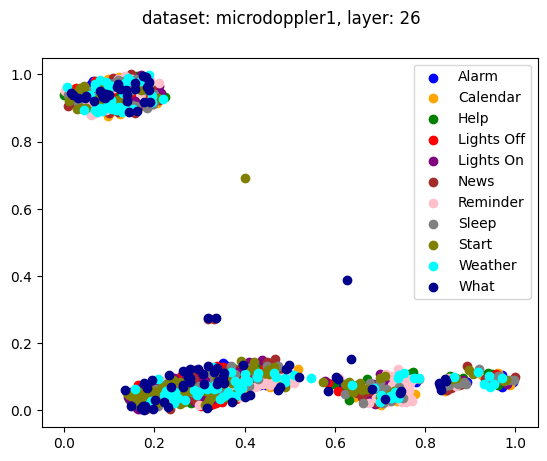

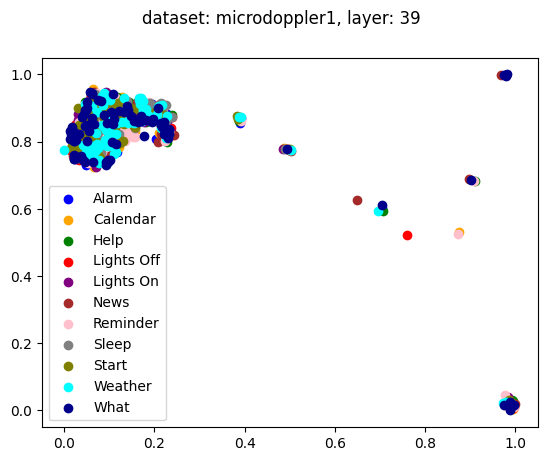

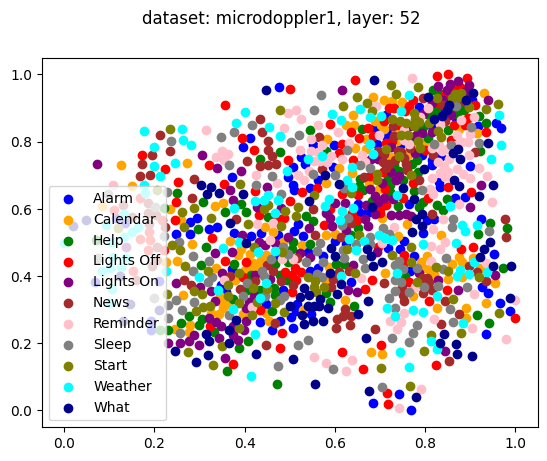

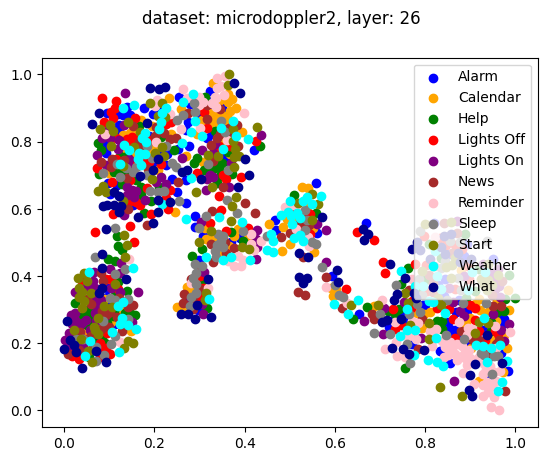

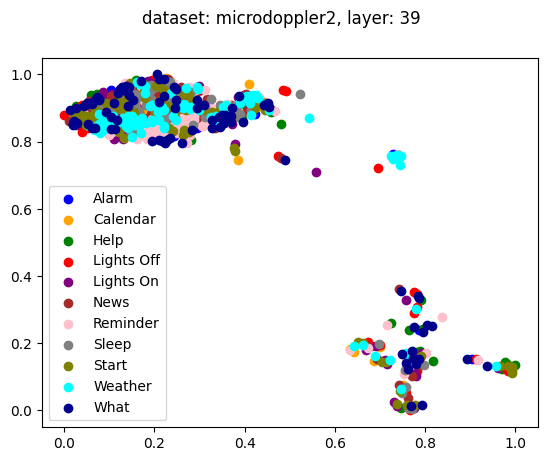

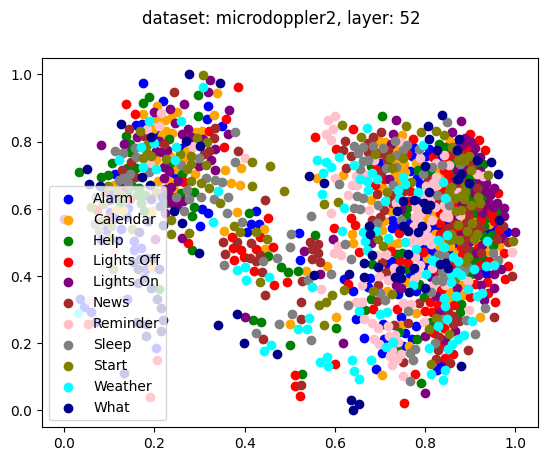

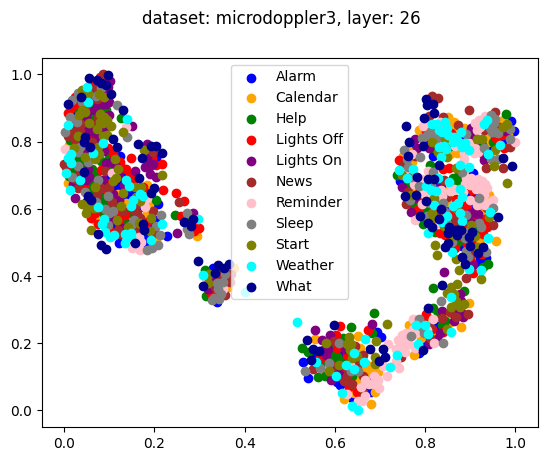

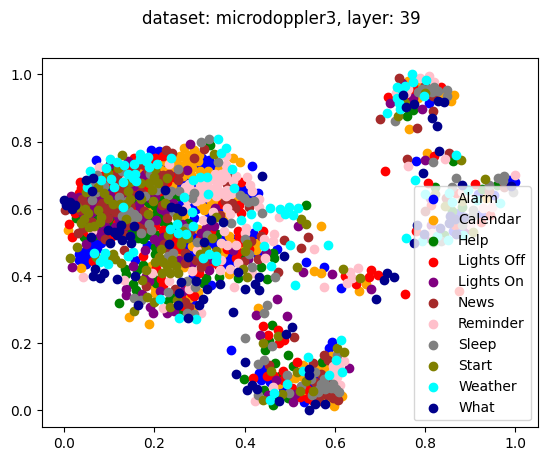

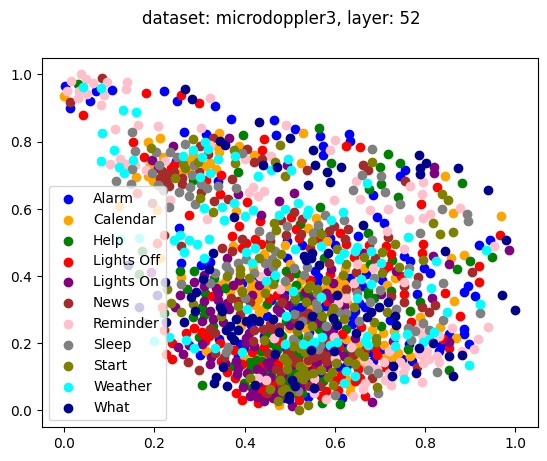

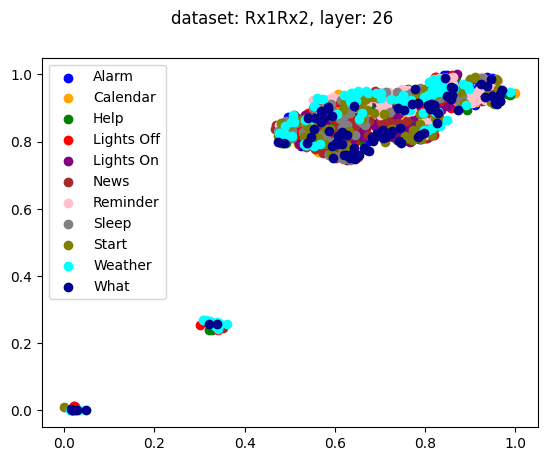

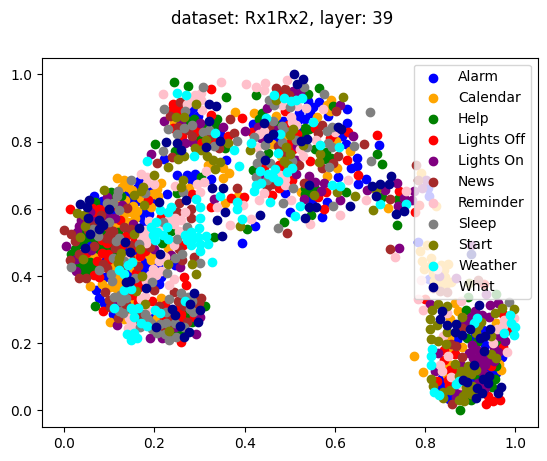

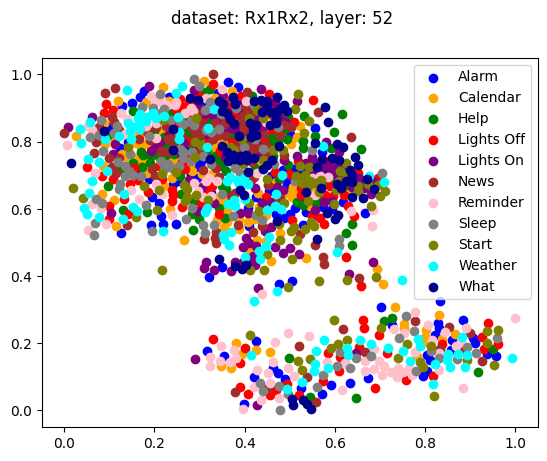

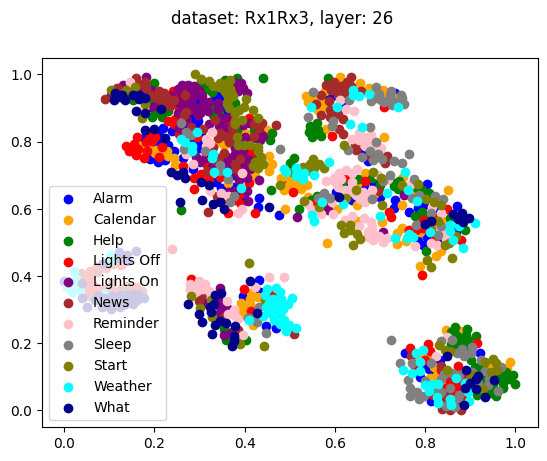

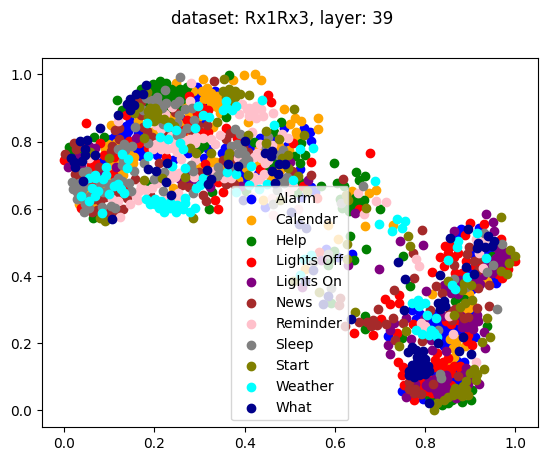

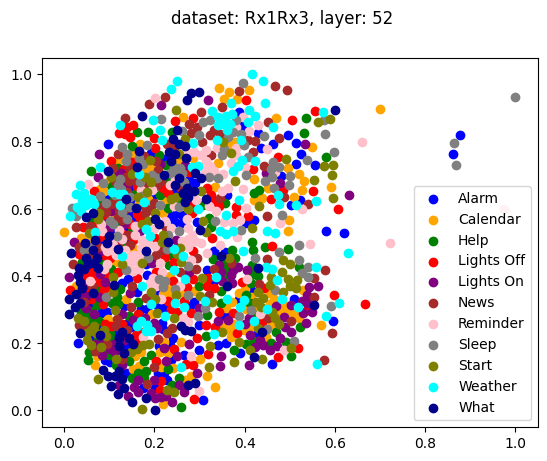

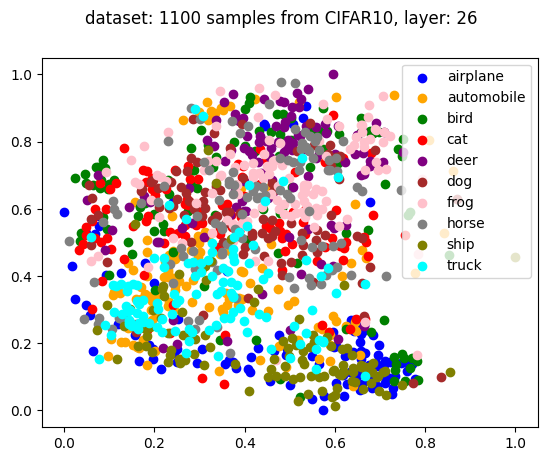

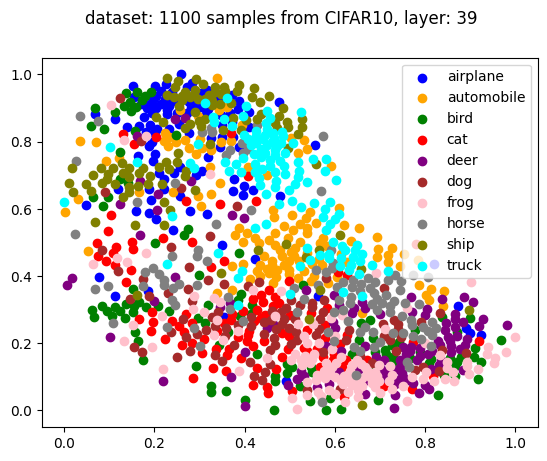

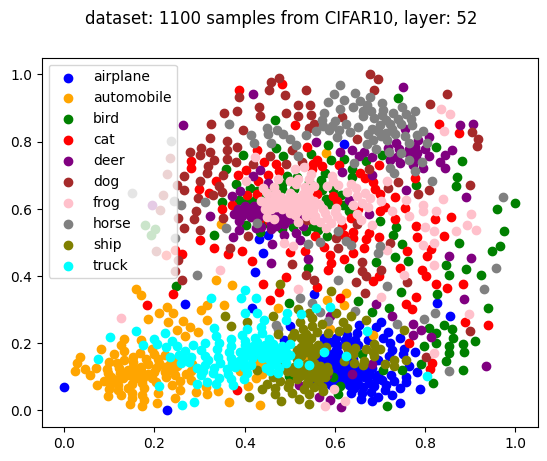

In [ ]:
#@title run TSNE

feature_layers=['26','39','52']

perplexity=15
learning_rate=10

batch_size=10

dataset_dirs=["/content/microdoppler_dataset/microdoppler1",
              "/content/microdoppler_dataset/microdoppler2",
              "/content/microdoppler_dataset/microdoppler3",
              "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2",
              "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3"
]

names=["microdoppler1",
       "microdoppler2",
       "microdoppler3",
       "Rx1Rx2",
       "Rx1Rx3"]

transform=transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((192,244)),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    #  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

def run_tsne(feature_extractor,perplexity,learning_rate):

  for dir,name in zip(dataset_dirs,names):

    dataset=ImageFolder(dir,transform)

    classes=dataset.classes

    plot_tsne(dataset,name,classes,feature_layers,perplexity,learning_rate)

  dataset=datasets.CIFAR10("./",download=True,transform=transform)
  subset=data.Subset(dataset,torch.arange(0,1099))

  name="1100 samples from CIFAR10"

  classes=dataset.classes

  plot_tsne(subset,name,classes,feature_layers,perplexity,learning_rate)

run_tsne(feature_extractor,perplexity,learning_rate)

!zip -r vgg19_bn.zip tsne

files.download("vgg19_bn.zip")

In [ ]:
#@title plot confusion matrices

def plot_confusion_matrix(pred,true):

  classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
          'Reminder', 'Sleep', 'Start','Weather', 'What')

  # classes = ('Alarm', 'Help', 'Lights Off',
  #         'Reminder', 'Sleep', 'Start','Weather', 'What')

  # Build confusion matrix
  cf_matrix = confusion_matrix(true, pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

In [ ]:
#@title regular vgg test

def run_vgg_test(dataset_dir,name,batch_size,num_epochs,lr):

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      #  transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
      ]
  )

  path_prefix=f"./regular_vgg"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  dataset=ImageFolder(dataset_dir,transform)

  train_set,val_set,test_set=data.random_split(dataset,[0.7,0.1,0.2],generator=torch.Generator())

  num_classes=len(dataset.classes)

  train_loader=data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
  val_loader=data.DataLoader(val_set,batch_size=batch_size,shuffle=True)
  test_loader=data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  model_name="{} VGG finetuning 21504 to 4096 to 11 classes".format(name)

  model=copy.deepcopy(feature_extractor)
  model.add_module('flatten',nn.Flatten())
  model.add_module('fc1',nn.Linear(21504,256))
  model.add_module('classifier_relu',nn.ReLU())
  model.add_module('dropout',nn.Dropout())
  model.add_module('fc2',nn.Linear(256,num_classes))

  for name,param in model.named_parameters():
    if param.requires_grad_:
      print(name)

  loss_function = nn.CrossEntropyLoss()
  # optimiser = optim.SGD(model.parameters(),lr=lr,momentum=momentum)
  optimiser = optim.Adam(model.parameters(),lr=lr)

  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  trial.with_generators(train_loader, val_generator=val_loader, test_generator=test_loader)
  trial.run(epochs=num_epochs)
  results = trial.evaluate(data_key=torchbearer.TEST_DATA)
  print(results)

  model_name_str="{}, {} epochs, relu_3_1,relu_4_1,relu_5_1, batch size {}, pool of 6 SGD, lr={}, mom={}, test_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,results['test_acc'])

  torch.save(model.state_dict(), '{}.pth'.format(model_name_str))

  model.eval()

  y_pred = []
  y_true = []

  with torch.no_grad():
    for inputs, labels in test_loader:
      output = model(inputs.to(device)) # Feed Network

      output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
      y_pred.extend(output) # Save Prediction

      labels = labels.data.cpu().numpy()
      y_true.extend(labels) # Save Truth

  # constant for classes
  classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
          'Reminder', 'Sleep', 'Start','Weather', 'What')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

  plt.savefig(path_prefix+'{}.png'.format(model_name_str))
  files.download(path_prefix+'{}.png'.format(model_name_str))

  return results

def run_vgg_test_k_fold(root_dir,name,
                        batch_size,
                        num_epochs,
                        lr,
                          k_fold_num):

  path_prefix=f"./vgg_test/{k_fold_num}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=ImageFolder(root_dir,transform)

  k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)
  # k_fold=model_selection.KFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  num_classes=len(dataset.classes)

  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset,list(dataset.targets))):
  # for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    val_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=train_sampler)
    val_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=val_sampler)

    model_name="{} vgg_test fold {}".format(name,fold+1)

    model=copy.deepcopy(feature_extractor)
    model.add_module('flatten',nn.Flatten())
    model.add_module('fc1',nn.Linear(21504,256))
    model.add_module('classifier_relu',nn.ReLU())
    model.add_module('dropout',nn.Dropout())
    model.add_module('fc2',nn.Linear(256,num_classes))

    loss_function = nn.CrossEntropyLoss()
    # loss_function = nn.MultiMarginLoss()

    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss')
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss',patience=5)

    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(train_loader,test_generator=val_loader)
    trial.run(epochs=num_epochs)

    val_acc=trial.evaluate(data_key=torchbearer.TEST_DATA)['test_acc']

    model.eval()

    val_loss=0.0

    y_val_pred=[]
    y_val_true=[]

    with torch.no_grad():

      for image_1,targets in tqdm(val_loader):

        image_1=image_1.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1)

        loss=loss_function(out,targets)

        val_loss+=loss.item()/image_1.shape[0]

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_val_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_val_true.extend(targets) # Save Truth

    # constant for classes
    classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
            'Reminder', 'Sleep', 'Start','Weather', 'What')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_val_true, y_val_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

    fold_results.append(val_acc)

  fold_average=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"AVG VALIDATION RESULT: {fold_average}")

  best_model_path=max(model_paths,key=model_paths.get)

  best_model_path_and_avg_val=best_model_path+", avg_val_acc={:.6f}".format(fold_average)

  os.rename(path_prefix+'/{}.png'.format(best_model_path),path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  files.download(path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  return fold_average

In [ ]:
# @title Single image network

class SingleClassifier(nn.Module):

  def __init__(self,num_classes):

    super().__init__()

    # self.finetuning_point=13
    self.finetuning_point=3

    self.fc1=nn.Linear(21504,256)
    self.fc2=nn.Linear(256,num_classes)

    # self.dropout=nn.Dropout(0.7)
    self.dropout=nn.Dropout()

  def get_vgg_outputs(self,name):
    def hook(model,input,output):
      self.vgg_outputs[name]=output
    return hook

  def init_vgg(self,vgg):
    self.vgg=vgg

    for index,child in enumerate(self.vgg.children()):
      for param in child.parameters():
        param.requires_grad_=False

    ### Finetuning specific layers

    # self.vgg[43]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[43].requires_grad_=True

    # self.vgg[46]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[46].requires_grad_=True

    # self.vgg[49]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[49].requires_grad_=True

    ### Finetuning output layers

    # for index,layer in enumerate(self.feature_layers):
    #   conv_layer_index_1,conv_layer_index_2=int(layer)-3,int(layer)-6
    #   num_channels=self.vgg_layer_channels[index+2]

    #   self.vgg[conv_layer_index_1]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    #   self.vgg[conv_layer_index_1].requires_grad_=True

    #   nn.init.xavier_normal(self.vgg[conv_layer_index_1].weight)
    #   if self.vgg[conv_layer_index_1].bias is not None:
    #     nn.init.zeros_(self.vgg[conv_layer_index_1].bias)

      # self.vgg[conv_layer_index_2]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
      # self.vgg[conv_layer_index_2].requires_grad_=True

      # nn.init.xavier_normal(self.vgg[conv_layer_index_2].weight)
      # if self.vgg[conv_layer_index_2].bias is not None:
      #   nn.init.zeros_(self.vgg[conv_layer_index_2].bias)


    ### Finetuning everything after a point

    # last_channel_num=0
    # for index,layer in enumerate(self.vgg[self.finetuning_point:]):
    #   index+=self.finetuning_point
    #   if isinstance(layer,nn.Conv2d):
    #     last_channel_num=layer.out_channels
    #     self.vgg[index]=nn.Conv2d(layer.in_channels,layer.out_channels,kernel_size=layer.kernel_size,stride=layer.stride,padding=layer.padding)
    #     self.vgg[index].requires_grad_=True
    #   elif isinstance(layer,nn.BatchNorm2d):
    #     self.vgg[index]=nn.BatchNorm2d(last_channel_num)
    #     self.vgg[index].requires_grad_=True

  def forward(self,doppler):

    encoding=self.vgg(doppler)

    flattened=torch.flatten(encoding,start_dim=1)

    out=self.fc1(flattened)
    out=self.dropout(out)
    out=F.relu(out)
    out=self.fc2(out)

    return out

class SingleGlobalPoolingClassifier(nn.Module):

  def __init__(self,num_classes):

    super().__init__()

    # self.finetuning_point=13
    self.finetuning_point=3

    self.pooling=nn.AdaptiveAvgPool2d(1)

    # self.fc1=nn.Linear(1408,1024)
    # self.fc2=nn.Linear(1024,num_classes)

    # self.fc1=nn.Linear(896,256)
    # self.fc2=nn.Linear(256,num_classes)

    self.fc1=nn.Linear(512,64)
    self.fc2=nn.Linear(64,num_classes)

    # self.fc1=nn.Linear(1024,22)
    # self.fc2=nn.Linear(22,num_classes)

    # self.fc1=nn.Linear(1280,128)
    # self.fc2=nn.Linear(128,num_classes)

    # self.fc1=nn.Linear(1536,64)
    # self.fc2=nn.Linear(64,num_classes)

    # self.fc1=nn.Linear(1408,256)
    # self.fc2=nn.Linear(256,num_classes)


    # self.dropout=nn.Dropout(0.7)
    self.dropout=nn.Dropout()

  def get_vgg_outputs(self,name):
    def hook(model,input,output):
      self.vgg_outputs[name]=output
    return hook

  def init_vgg(self,vgg):
    self.vgg=vgg

    for index,child in enumerate(self.vgg.children()):
      for param in child.parameters():
        param.requires_grad_=False

    ### Finetuning specific layers

    # self.vgg[43]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[43].requires_grad_=True

    # self.vgg[46]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[46].requires_grad_=True

    # self.vgg[49]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[49].requires_grad_=True

    ### Finetuning output layers

    # for index,layer in enumerate(self.feature_layers):
    #   conv_layer_index_1,conv_layer_index_2=int(layer)-3,int(layer)-6
    #   num_channels=self.vgg_layer_channels[index+2]

    #   self.vgg[conv_layer_index_1]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    #   self.vgg[conv_layer_index_1].requires_grad_=True

    #   nn.init.xavier_normal(self.vgg[conv_layer_index_1].weight)
    #   if self.vgg[conv_layer_index_1].bias is not None:
    #     nn.init.zeros_(self.vgg[conv_layer_index_1].bias)

      # self.vgg[conv_layer_index_2]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
      # self.vgg[conv_layer_index_2].requires_grad_=True

      # nn.init.xavier_normal(self.vgg[conv_layer_index_2].weight)
      # if self.vgg[conv_layer_index_2].bias is not None:
      #   nn.init.zeros_(self.vgg[conv_layer_index_2].bias)


    ### Finetuning everything after a point

    # last_channel_num=0
    # for index,layer in enumerate(self.vgg[self.finetuning_point:]):
    #   index+=self.finetuning_point
    #   if isinstance(layer,nn.Conv2d):
    #     last_channel_num=layer.out_channels
    #     self.vgg[index]=nn.Conv2d(layer.in_channels,layer.out_channels,kernel_size=layer.kernel_size,stride=layer.stride,padding=layer.padding)
    #     self.vgg[index].requires_grad_=True
    #   elif isinstance(layer,nn.BatchNorm2d):
    #     self.vgg[index]=nn.BatchNorm2d(last_channel_num)
    #     self.vgg[index].requires_grad_=True

  def forward(self,doppler):

    encoding=self.vgg(doppler)

    pooled=self.pooling(encoding)

    out=self.fc1(torch.squeeze(pooled,dim=(2,3)))
    out=self.dropout(out)
    out=F.relu(out)
    out=self.fc2(out)

    return out

def run_single_image_classifier(root_dir,name,
                                            batch_size,
                                            num_epochs,
                                            lr,
                                            copy_num,
                                            global_pooling=True):

  aug_transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
      AddGaussianNoise()
      ]
  )


  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=ImageFolder(root_dir,transform)

  train_set,test_set=data.random_split(dataset,[0.7,0.3],generator=torch.Generator())
  # train_set,val_set,test_set=data.random_split(dataset,[0.7,0.1,0.2],generator=torch.Generator())

  augmented_train_sets=[copy.deepcopy(train_set) for i in range(copy_num)]

  for _set in augmented_train_sets:
    _set.transform=aug_transform

  train_set.transform=transform
  # val_set.transform=transform
  test_set.transform=transform

  train_set=data.ConcatDataset([train_set,*augmented_train_sets])

  num_classes=len(dataset.classes)

  train_loader=data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
  # val_loader=data.DataLoader(val_set,batch_size=batch_size,shuffle=True)
  test_loader=data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  if global_pooling:
    path_prefix=f"./single GAP"
    model_name="{} GAP".format(name)
    model=SingleGlobalPoolingClassifier(num_classes).to(device)
  else:
    path_prefix=f"./single"
    model_name="{}".format(name)
    model=SingleClassifier(num_classes).to(device)

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model.apply(init_weights)
  model.init_vgg(copy.deepcopy(feature_extractor))

  for name,param in model.named_parameters():
    if param.requires_grad_:
      print(name)

  loss_function = nn.CrossEntropyLoss()
  # loss_function = nn.MultiMarginLoss()

  optimiser = optim.Adam(model.parameters(),lr=lr)
  # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss')
  # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss',patience=5)

  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  # trial = Trial(model, optimiser, loss_function, callbacks=[scheduler], metrics=['loss', 'accuracy']).to(device)
  # trial.with_generators(train_loader,val_generator=val_loader,test_generator=test_loader)
  trial.with_generators(train_loader,test_generator=test_loader)
  trial.run(epochs=num_epochs)

  results=trial.evaluate(data_key=torchbearer.TEST_DATA)

  print(results)

  model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, copy_num={}, test_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,copy_num,results['test_acc'])

  torch.save(model.state_dict(), '{}.pth'.format(model_name_str))

  model.eval()

  y_pred = []
  y_true = []

  with torch.no_grad():
    for inputs, labels in test_loader:
      output = model(inputs.to(device)) # Feed Network

      output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
      y_pred.extend(output) # Save Prediction

      labels = labels.data.cpu().numpy()
      y_true.extend(labels) # Save Truth

  # constant for classes
  classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
          'Reminder', 'Sleep', 'Start','Weather', 'What')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.savefig(path_prefix+'{}.png'.format(model_name_str))
  files.download(path_prefix+'{}.png'.format(model_name_str))

  return results

def run_single_classifier_k_fold(root_dir,name,
                                  batch_size,
                                  num_epochs,
                                  lr,
                                    k_fold_num,
                                  global_pooling=True):

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=ImageFolder(root_dir,transform)

  k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)
  # k_fold=model_selection.KFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  num_classes=len(dataset.classes)

  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  if global_pooling:
    path_prefix=f"./single GAP/{k_fold_num}"
    model=SingleGlobalPoolingClassifier(num_classes).to(device)
  else:
    path_prefix=f"./single/{k_fold_num}"
    model=SingleClassifier(num_classes).to(device)

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  print(batch_size)

  for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset,list(dataset.targets))):
  # for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    val_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=train_sampler)
    val_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=val_sampler)

    if global_pooling:
      model_name="{} single GAP fold {}".format(name,fold+1)
    else:
      model_name="{} single fold {}".format(name,fold+1)

    model.apply(init_weights)
    model.init_vgg(copy.deepcopy(feature_extractor))

    loss_function = nn.CrossEntropyLoss()
    # loss_function = nn.MultiMarginLoss()

    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss')
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss',patience=5)

    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(train_loader,test_generator=val_loader)
    trial.run(epochs=num_epochs)

    val_acc=trial.evaluate(data_key=torchbearer.TEST_DATA)['test_acc']

    model.eval()

    val_loss=0.0

    y_val_pred=[]
    y_val_true=[]

    with torch.no_grad():

      for image_1,targets in tqdm(val_loader):

        image_1=image_1.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1)

        loss=loss_function(out,targets)

        val_loss+=loss.item()/image_1.shape[0]

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_val_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_val_true.extend(targets) # Save Truth

    # constant for classes
    classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
            'Reminder', 'Sleep', 'Start','Weather', 'What')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_val_true, y_val_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

    fold_results.append(val_acc)

  fold_average=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"AVG VALIDATION RESULT: {fold_average}")

  best_model_path=max(model_paths,key=model_paths.get)

  best_model_path_and_avg_val="{}, {} epochs, batch {}, Adam, lr={}, avg_val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,fold_average)

  os.rename(path_prefix+'/{}.png'.format(best_model_path),path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  files.download(path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  return fold_average

def run_single_multi_depth_classifier_k_fold_holdout(root_dir,name,
                                                            batch_size,
                                                            num_epochs,
                                                            lr,
                                                            k_fold_num,
                                                            global_pooling=True):

  path_prefix=f"./single/{k_fold_num}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=ImageFolder(root_dir,transform)

  fold_set,holdout_set=data.random_split(dataset,[0.8,0.2],generator=torch.Generator())

  k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  for fold,(train_indices,test_indices) in enumerate(k_fold.split(fold_set,fold_set.targets)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    val_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(fold_set,batch_size=batch_size,sampler=train_sampler)
    val_loader=data.DataLoader(fold_set,batch_size=batch_size,sampler=val_sampler)

    num_classes=len(dataset.classes)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    if global_pooling:
      model_name="{} single fold {}".format(name,fold+1)

      model=SingleMultiDepthGlobalSelfAttentionGlobalPoolingClassifier(feature_extractor,num_classes).to(device)
    else:
      model_name="{} single fold {}".format(name,fold+1)

      model=SingleMultiDepthGlobalSelfAttentionClassifier(feature_extractor,num_classes).to(device)

    model.apply(init_weights)

    loss_function = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss')
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss',patience=5)

    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(train_loader,test_generator=val_loader)
    trial.run(epochs=num_epochs)

    val_acc=trial.evaluate(data_key=torchbearer.TEST_DATA)['test_acc']

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    fold_results.append(val_acc)

  if global_pooling:
    model_name="{} single {} folds".format(name,k_fold_num)

    model=SingleGlobalPoolingClassifier(feature_extractor,num_classes).to(device)
  else:
    model_name="{} single {} folds".format(name,k_fold_num)

    model=SingleMultiDepthGlobalSelfAttentionClassifier(feature_extractor,num_classes).to(device)

  best_model_path=max(model_paths,key=model_paths.get)

  time.sleep(10) #Wait for the last model to save in case it was the best

  model.load_state_dict(torch.load(path_prefix+"/"+best_model_path+".pth"))

  model.eval()

  holdout_loader=data.DataLoader(holdout_set,batch_size=batch_size)

  y_test_pred=[]
  y_test_true=[]

  with torch.no_grad():
    for doppler,targets in holdout_loader:
      out = model(doppler.to(device)) # Feed Network

      predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
      y_test_pred.extend(predictions) # Save Prediction

      targets = targets.data.cpu().numpy()
      y_test_true.extend(targets) # Save Truth

  # constant for classes
  classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
          'Reminder', 'Sleep', 'Start','Weather', 'What')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_test_true, y_test_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

  count=0

  for pred,true in zip(y_test_pred,y_test_true):
    if pred==true:count+=1

  test_acc=float(count/len(y_test_pred))
  average_val_acc=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"HOLDOUT TEST RESULT: {test_acc}")
  print(f"AVERAGE VALIDATION ACCURACY: {average_val_acc}")

  model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, test_acc={:.6f} avg_val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,test_acc,average_val_acc)

  plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

  files.download(path_prefix+'/{}.png'.format(model_name_str))

  return test_acc

In [ ]:
# @title Single image multi-depth network

class SingleMultiDepthClassifier(nn.Module):

  def __init__(self,num_classes):

    super().__init__()

    # self.feature_layers=['7','14','21','28']
    # self.feature_layers=['14','21','28']
    # self.feature_layers=['21','28']
    # self.feature_layers=['5','10','15','20']
    # self.feature_layers=['10','15','20']
    # self.feature_layers=['15','20']

    # self.feature_layers=['26','39','52'] #relus
    # self.feature_layers=['29','42','52'] #max pools

    self.feature_layers=['42','52']

    self.vgg_layer_channels=[64,128,256,512,512]
    self.vgg_outputs={}

    self.fc1=nn.Linear(43008,256)
    self.fc2=nn.Linear(256,num_classes)

    # self.dropout=nn.Dropout(0.7)
    self.dropout=nn.Dropout()

  def get_vgg_outputs(self,name):
    def hook(model,input,output):
      self.vgg_outputs[name]=output
    return hook

  def init_vgg(self,vgg):
    self.vgg=vgg

    for index,child in enumerate(self.vgg.children()):
      for param in child.parameters():
        param.requires_grad_=False

    ### Finetuning

    # self.vgg[43]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[43].requires_grad_=True

    # self.vgg[46]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[46].requires_grad_=True

    # self.vgg[49]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[49].requires_grad_=True


    # for index,layer in enumerate(self.feature_layers):
    #   conv_layer_index_1,conv_layer_index_2=int(layer)-3,int(layer)-6
    #   num_channels=self.vgg_layer_channels[index+2]

    #   self.vgg[conv_layer_index_1]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    #   self.vgg[conv_layer_index_1].requires_grad_=True

    #   nn.init.xavier_normal(self.vgg[conv_layer_index_1].weight)
    #   if self.vgg[conv_layer_index_1].bias is not None:
    #     nn.init.zeros_(self.vgg[conv_layer_index_1].bias)

      # self.vgg[conv_layer_index_2]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
      # self.vgg[conv_layer_index_2].requires_grad_=True

      # nn.init.xavier_normal(self.vgg[conv_layer_index_2].weight)
      # if self.vgg[conv_layer_index_2].bias is not None:
      #   nn.init.zeros_(self.vgg[conv_layer_index_2].bias)

    for name in self.feature_layers:
      getattr(self.vgg,name).register_forward_hook(self.get_vgg_outputs(name))

  def forward(self,doppler):

    doppler_convs=[]

    self.vgg(doppler)

    for feature_layer in self.feature_layers:
      doppler_convs.append(self.vgg_outputs[feature_layer])

    outs=[]

    global_doppler_conv=doppler_convs.pop()

    for doppler_conv in zip(doppler_convs):

      downscaled_doppler_conv=F.interpolate(doppler_conv[0],(global_doppler_conv.shape[2],global_doppler_conv.shape[3]))

      outs.append(downscaled_doppler_conv)

    outs.append(global_doppler_conv)

    cat_pools=torch.cat(outs,dim=1)

    flattened_cat_pools=torch.flatten(cat_pools,start_dim=1)

    out=self.fc1(flattened_cat_pools)
    out=self.dropout(out)
    out=F.relu(out)
    out=self.fc2(out)

    return out

class SingleMultiDepthGlobalPoolingClassifier(nn.Module):

  def __init__(self,num_classes):

    super().__init__()

    # self.feature_layers=['7','14','21','28']
    # self.feature_layers=['14','21','28']
    # self.feature_layers=['21','28']
    # self.feature_layers=['5','10','15','20']
    # self.feature_layers=['10','15','20']
    # self.feature_layers=['15','20']


    self.feature_layers=['26','39','52'] #relus
    # self.feature_layers=['29','42','52'] #max pools

    self.vgg_layer_channels=[64,128,256,512,512]
    self.vgg_outputs={}

    self.pooling=nn.AdaptiveAvgPool2d(1)

    # self.fc1=nn.Linear(1408,1024)
    # self.fc2=nn.Linear(1024,num_classes)

    # self.fc1=nn.Linear(896,256)
    # self.fc2=nn.Linear(256,num_classes)

    self.fc1=nn.Linear(1280,256)
    self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(1024,22)
    # self.fc2=nn.Linear(22,num_classes)

    # self.fc1=nn.Linear(1280,128)
    # self.fc2=nn.Linear(128,num_classes)

    # self.fc1=nn.Linear(1536,64)
    # self.fc2=nn.Linear(64,num_classes)

    # self.fc1=nn.Linear(1408,256)
    # self.fc2=nn.Linear(256,num_classes)


    # self.dropout=nn.Dropout(0.7)
    self.dropout=nn.Dropout()

  def get_vgg_outputs(self,name):
    def hook(model,input,output):
      self.vgg_outputs[name]=output
    return hook

  def init_vgg(self,vgg):
    self.vgg=vgg

    for index,child in enumerate(self.vgg.children()):
      for param in child.parameters():
        param.requires_grad_=False

    ### Finetuning

    # self.vgg[43]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[43].requires_grad_=True

    # self.vgg[46]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[46].requires_grad_=True

    # self.vgg[49]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[49].requires_grad_=True


    # for index,layer in enumerate(self.feature_layers):
    #   conv_layer_index_1,conv_layer_index_2=int(layer)-3,int(layer)-6
    #   num_channels=self.vgg_layer_channels[index+2]

    #   self.vgg[conv_layer_index_1]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    #   self.vgg[conv_layer_index_1].requires_grad_=True

    #   nn.init.xavier_normal(self.vgg[conv_layer_index_1].weight)
    #   if self.vgg[conv_layer_index_1].bias is not None:
    #     nn.init.zeros_(self.vgg[conv_layer_index_1].bias)

      # self.vgg[conv_layer_index_2]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
      # self.vgg[conv_layer_index_2].requires_grad_=True

      # nn.init.xavier_normal(self.vgg[conv_layer_index_2].weight)
      # if self.vgg[conv_layer_index_2].bias is not None:
      #   nn.init.zeros_(self.vgg[conv_layer_index_2].bias)

    for name in self.feature_layers:
      getattr(self.vgg,name).register_forward_hook(self.get_vgg_outputs(name))

  def forward(self,doppler):

    doppler_convs=[]

    self.vgg(doppler)

    for feature_layer in self.feature_layers:
      doppler_convs.append(self.vgg_outputs[feature_layer])

    outs=[]

    global_doppler_conv=doppler_convs.pop()

    for doppler_conv in zip(doppler_convs):

      downscaled_doppler_conv=F.interpolate(doppler_conv[0],(global_doppler_conv.shape[2],global_doppler_conv.shape[3]))
      # upscaled_global_conv=F.interpolate(global_doppler_conv,(doppler_conv.shape[2],doppler_conv.shape[3]))

      # normed=norm(current_out)

      pooled=self.pooling(downscaled_doppler_conv)
      # pooled=self.pooling(normed)

      outs.append(torch.squeeze(pooled,dim=(2,3)))

    outs.append(torch.squeeze(self.pooling(global_doppler_conv),dim=(2,3)))
    # outs.append(torch.squeeze(self.pooling(self.batch_norm_modules[-1](global_doppler_conv)),dim=(2,3)))

    cat_pools=torch.cat(outs,dim=1)

    flattened_cat_pools=torch.flatten(cat_pools,start_dim=1)

    out=self.fc1(flattened_cat_pools)
    out=self.dropout(out)
    out=F.relu(out)
    out=self.fc2(out)

    return out

def run_single_image_multi_depth_classifier(root_dir,
                                            name,
                                            batch_size,
                                            num_epochs,
                                            lr,
                                            copy_num,
                                            global_pooling=True):

  path_prefix=f"./single multi-depth/"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  aug_transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
      AddGaussianNoise()
      ]
  )


  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=ImageFolder(root_dir,transform)

  train_set,test_set=data.random_split(dataset,[0.7,0.3],generator=torch.Generator())
  # train_set,test_set=data.random_split(dataset,[0.8,0.2],generator=torch.Generator())
  # train_set,val_set,test_set=data.random_split(dataset,[0.7,0.2,0.1],generator=torch.Generator())
  # train_set,val_set,test_set=data.random_split(dataset,[0.6,0.3,0.1],generator=torch.Generator())

  augmented_train_sets=[copy.deepcopy(train_set) for i in range(copy_num)]

  for _set in augmented_train_sets:
    _set.transform=aug_transform

  train_set.transform=transform
  # val_set.transform=transform
  test_set.transform=transform

  train_set=data.ConcatDataset([train_set,*augmented_train_sets])

  num_classes=len(dataset.classes)

  train_loader=data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
  # val_loader=data.DataLoader(val_set,batch_size=batch_size,shuffle=True)
  test_loader=data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

  device = "cuda:0" if torch.cuda.is_available() else "cpu"


  if global_pooling:
    model=SingleMultiDepthGlobalPoolingClassifier(num_classes).to(device)
    model_name="{} multi GAP".format(name)
  else:
    model=SingleMultiDepthClassifier(num_classes).to(device)
    model_name="{} multi".format(name)

  model.apply(init_weights)
  model.init_vgg(copy.deepcopy(feature_extractor))

  for name,param in model.named_parameters():
    if param.requires_grad_:
      print(name)

  loss_function = nn.CrossEntropyLoss()
  # loss_function = nn.MultiMarginLoss()

  optimiser = optim.Adam(model.parameters(),lr=lr)
  # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss')
  # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss',patience=5)

  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  # trial = Trial(model, optimiser, loss_function, callbacks=[scheduler], metrics=['loss', 'accuracy']).to(device)
  # trial.with_generators(train_loader,val_generator=val_loader,test_generator=test_loader)
  trial.with_generators(train_loader,test_generator=test_loader)
  trial.run(epochs=num_epochs)

  results=trial.evaluate(data_key=torchbearer.TEST_DATA)

  print(results)

  model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, copy_num={}, test_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,copy_num,results['test_acc'])

  torch.save(model.state_dict(), '{}.pth'.format(model_name_str))

  model.eval()

  y_pred = []
  y_true = []

  with torch.no_grad():
    for inputs, labels in test_loader:
      output = model(inputs.to(device)) # Feed Network

      output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
      y_pred.extend(output) # Save Prediction

      labels = labels.data.cpu().numpy()
      y_true.extend(labels) # Save Truth

  plot_confusion_matrix(y_pred,y_true)

  plt.savefig(path_prefix+'{}.png'.format(model_name_str))

  files.download(path_prefix+'{}.png'.format(model_name_str))

  return results

def run_single_multi_depth_classifier_k_fold(root_dir,
                                              name,
                                              batch_size,
                                              num_epochs,
                                              lr,
                                              k_fold_num,
                                              global_pooling=True):

  path_prefix=f"./single/{k_fold_num}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=ImageFolder(root_dir,transform)

  k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)
  # k_fold=model_selection.KFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  num_classes=len(dataset.classes)

  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  if global_pooling:
    model=SingleMultiDepthGlobalPoolingClassifier(num_classes).to(device)
    model_name="{} multi GAP".format(name)
  else:
    model=SingleMultiDepthClassifier(num_classes).to(device)
    model_name="{} multi".format(name)

  for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset,list(dataset.targets))):
  # for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    val_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=train_sampler)
    val_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=val_sampler)


    if global_pooling:
      model=SingleMultiDepthGlobalPoolingClassifier(num_classes).to(device)
      model_name="{} multi GAP fold {}".format(name,fold+1)
    else:
      model=SingleMultiDepthClassifier(num_classes).to(device)
      model_name="{} multi fold {}".format(name,fold+1)

    model.apply(init_weights)
    model.init_vgg(copy.deepcopy(feature_extractor))

    loss_function = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss')
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss',patience=5)

    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(train_loader,test_generator=val_loader)
    trial.run(epochs=num_epochs)

    val_acc=trial.evaluate(data_key=torchbearer.TEST_DATA)['test_acc']

    model.eval()

    val_loss=0.0

    y_val_pred=[]
    y_val_true=[]

    with torch.no_grad():

      for image_1,targets in tqdm(val_loader):

        image_1=image_1.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1)

        loss=loss_function(out,targets)

        val_loss+=loss.item()/image_1.shape[0]

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_val_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_val_true.extend(targets) # Save Truth

    # constant for classes
    classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
            'Reminder', 'Sleep', 'Start','Weather', 'What')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_val_true, y_val_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

    fold_results.append(val_acc)

  fold_average=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"AVG VALIDATION RESULT: {fold_average}")

  best_model_path=max(model_paths,key=model_paths.get)

  best_model_path_and_avg_val="{}, {} epochs, batch {}, Adam, lr={}, avg_val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,fold_average)

  os.rename(path_prefix+'/{}.png'.format(best_model_path),path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  files.download(path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  return fold_average

def run_single_multi_depth_classifier_k_fold_holdout(root_dir,name,
                                                            batch_size,
                                                            num_epochs,
                                                            lr,
                                                            k_fold_num,
                                                            global_pooling=True):

  path_prefix=f"./single/{k_fold_num}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=ImageFolder(root_dir,transform)

  fold_set,holdout_set=data.random_split(dataset,[0.8,0.2],generator=torch.Generator())

  k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  for fold,(train_indices,test_indices) in enumerate(k_fold.split(fold_set,fold_set.targets)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    val_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(fold_set,batch_size=batch_size,sampler=train_sampler)
    val_loader=data.DataLoader(fold_set,batch_size=batch_size,sampler=val_sampler)

    num_classes=len(dataset.classes)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    if global_pooling:
      model_name="{} single fold {}".format(name,fold+1)

      model=SingleMultiDepthGlobalSelfAttentionGlobalPoolingClassifier(feature_extractor,num_classes).to(device)
    else:
      model_name="{} single fold {}".format(name,fold+1)

      model=SingleMultiDepthGlobalSelfAttentionClassifier(feature_extractor,num_classes).to(device)

    model.apply(init_weights)

    loss_function = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss')
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss',patience=5)

    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(train_loader,test_generator=val_loader)
    trial.run(epochs=num_epochs)

    val_acc=trial.evaluate(data_key=torchbearer.TEST_DATA)['test_acc']

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    fold_results.append(val_acc)

  if global_pooling:
    model_name="{} single {} folds".format(name,k_fold_num)

    model=SingleMultiDepthGlobalSelfAttentionGlobalPoolingClassifier(feature_extractor,num_classes).to(device)
  else:
    model_name="{} single {} folds".format(name,k_fold_num)

    model=SingleMultiDepthGlobalSelfAttentionClassifier(feature_extractor,num_classes).to(device)

  best_model_path=max(model_paths,key=model_paths.get)

  time.sleep(10) #Wait for the last model to save in case it was the best

  model.load_state_dict(torch.load(path_prefix+"/"+best_model_path+".pth"))

  model.eval()

  holdout_loader=data.DataLoader(holdout_set,batch_size=batch_size)

  y_test_pred=[]
  y_test_true=[]

  with torch.no_grad():
    for doppler,targets in holdout_loader:
      out = model(doppler.to(device)) # Feed Network

      predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
      y_test_pred.extend(predictions) # Save Prediction

      targets = targets.data.cpu().numpy()
      y_test_true.extend(targets) # Save Truth

  # constant for classes
  classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
          'Reminder', 'Sleep', 'Start','Weather', 'What')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_test_true, y_test_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

  count=0

  for pred,true in zip(y_test_pred,y_test_true):
    if pred==true:count+=1

  test_acc=float(count/len(y_test_pred))
  average_val_acc=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"HOLDOUT TEST RESULT: {test_acc}")
  print(f"AVERAGE VALIDATION ACCURACY: {average_val_acc}")

  model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, test_acc={:.6f} avg_val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,test_acc,average_val_acc)

  plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

  files.download(path_prefix+'/{}.png'.format(model_name_str))

  return test_acc

In [ ]:
# @title Single image global self attention network

class SingleMultiDepthGlobalSelfAttentionClassifier(nn.Module):

  def __init__(self,num_classes):

    super().__init__()

    # self.feature_layers=['7','14','21','28']
   # self.feature_layers=['14','21','28']
    # self.feature_layers=['10','17','28']
    # self.feature_layers=['21','28']
    # self.feature_layers=['5','10','15','20']
    # self.feature_layers=['10','15','20']
    # self.feature_layers=['15','20']

    # self.feature_layers=['23','33','43']
    # self.feature_layers=['16','26','43']
    # self.feature_layers=['43']
    # self.feature_layers=['9','16','26','43']

    # self.feature_layers=['26','39','52'] #relus
    self.feature_layers=['29','42','52'] #max pools

    self.finetuning_point=13

    # self.feature_layers=['4','7','9','12']

    self.vgg_layer_channels=[64,128,256,512,512]
    # self.vgg_layer_channels=[3,64,192,384,256,256]
    self.vgg_outputs={}

    self.attention_modules=nn.ModuleList([Attn(channels,channels,channels,channels,self.vgg_layer_channels[-1],channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):-1]])
    # self.attention_modules=nn.ModuleList([PooledAttn(channels,channels,channels,channels,self.vgg_layer_channels[-1],channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):-1]])

    # self.fc1=nn.Linear(1408,1024)
    # self.fc2=nn.Linear(1024,num_classes)

    # self.fc1=nn.Linear(896,256)
    # self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(512,64)
    # self.fc2=nn.Linear(64,num_classes)

    # self.fc1=nn.Linear(1088,256)
    # self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(1024,22)
    # self.fc2=nn.Linear(22,num_classes)

    self.fc1=nn.Linear(1280,256)
    self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(1536,64)
    # self.fc2=nn.Linear(64,num_classes)

    # self.fc1=nn.Linear(1408,512)
    # self.fc2=nn.Linear(512,num_classes)


    # self.dropout=nn.Dropout(0.7)
    self.dropout=nn.Dropout()

  def get_vgg_outputs(self,name):
    def hook(model,input,output):
      self.vgg_outputs[name]=output
    return hook

  def init_vgg(self,vgg):
    self.vgg=vgg

    for index,child in enumerate(self.vgg.children()):
      for param in child.parameters():
        param.requires_grad_=False

    ### Finetuning specific layers

    # self.vgg[43]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[43].requires_grad_=True

    # self.vgg[46]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[46].requires_grad_=True

    # self.vgg[49]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[49].requires_grad_=True

    ### Finetuning output layers

    # for index,layer in enumerate(self.feature_layers):
    #   conv_layer_index_1,conv_layer_index_2=int(layer)-3,int(layer)-6
    #   num_channels=self.vgg_layer_channels[index+2]

    #   self.vgg[conv_layer_index_1]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    #   self.vgg[conv_layer_index_1].requires_grad_=True

    #   nn.init.xavier_normal(self.vgg[conv_layer_index_1].weight)
    #   if self.vgg[conv_layer_index_1].bias is not None:
    #     nn.init.zeros_(self.vgg[conv_layer_index_1].bias)

      # self.vgg[conv_layer_index_2]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
      # self.vgg[conv_layer_index_2].requires_grad_=True

      # nn.init.xavier_normal(self.vgg[conv_layer_index_2].weight)
      # if self.vgg[conv_layer_index_2].bias is not None:
      #   nn.init.zeros_(self.vgg[conv_layer_index_2].bias)


    ### Finetuning everything after a point

    # last_channel_num=0
    # for index,layer in enumerate(self.vgg[self.finetuning_point:]):
    #   index+=self.finetuning_point
    #   if isinstance(layer,nn.Conv2d):
    #     last_channel_num=layer.out_channels
    #     self.vgg[index]=nn.Conv2d(layer.in_channels,layer.out_channels,kernel_size=layer.kernel_size,stride=layer.stride,padding=layer.padding)
    #     self.vgg[index].requires_grad_=True
    #   elif isinstance(layer,nn.BatchNorm2d):
    #     self.vgg[index]=nn.BatchNorm2d(last_channel_num)
    #     self.vgg[index].requires_grad_=True

    for name in self.feature_layers:
      getattr(self.vgg,name).register_forward_hook(self.get_vgg_outputs(name))

  def forward(self,doppler):

    doppler_convs=[]

    self.vgg(doppler)

    for feature_layer in self.feature_layers:
      doppler_convs.append(self.vgg_outputs[feature_layer])

    outs=[]

    global_doppler_conv=doppler_convs.pop()

    for doppler_conv,attn,norm in zip(doppler_convs,self.attention_modules,self.batch_norm_modules):

      downscaled_doppler_conv=F.interpolate(doppler_conv,(global_doppler_conv.shape[2],global_doppler_conv.shape[3]))
      current_out=attn(downscaled_doppler_conv,downscaled_doppler_conv,global_doppler_conv)

      # upscaled_global_conv=F.interpolate(global_doppler_conv,(doppler_conv.shape[2],doppler_conv.shape[3]))
      # current_out=attn(doppler_conv,doppler_conv,upscaled_global_conv)

      # normed=norm(current_out)
      # pooled=self.pooling(normed)

      outs.append(current_out)

    outs.append(global_doppler_conv)
    # outs.append(torch.squeeze(self.pooling(self.batch_norm_modules[-1](global_doppler_conv)),dim=(2,3)))

    cat_pools=torch.cat(outs,dim=1)

    flattened_cat_pools=torch.flatten(cat_pools,start_dim=1)

    out=self.fc1(flattened_cat_pools)
    out=self.dropout(out)
    out=F.relu(out)
    out=self.fc2(out)

    return out

class SingleMultiDepthGlobalSelfAttentionGlobalPoolingClassifier(nn.Module):

  def __init__(self,num_classes):

    super().__init__()

    # self.feature_layers=['7','14','21','28']
   # self.feature_layers=['14','21','28']
    # self.feature_layers=['10','17','28']
    # self.feature_layers=['21','28']
    # self.feature_layers=['5','10','15','20']
    # self.feature_layers=['10','15','20']
    # self.feature_layers=['15','20']

    # self.feature_layers=['23','33','43']
    # self.feature_layers=['16','26','43']
    # self.feature_layers=['43']
    # self.feature_layers=['9','16','26','43']

    self.feature_layers=['26','39','52']

    self.finetuning_point=13

    # self.feature_layers=['4','7','9','12']

    self.vgg_layer_channels=[64,128,256,512,512]
    # self.vgg_layer_channels=[3,64,192,384,256,256]
    self.vgg_outputs={}

    self.attention_modules=nn.ModuleList([Attn(channels,channels,channels,channels,self.vgg_layer_channels[-1],channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):-1]])
    # self.attention_modules=nn.ModuleList([PooledAttn(channels,channels,channels,channels,self.vgg_layer_channels[-1],channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):-1]])
    self.batch_norm_modules=nn.ModuleList([nn.BatchNorm2d(channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):]])

    # self.spatial_attention_modules=nn.ModuleList([SpatialAttn(channels,self.vgg_layer_channels[-1]) for channels in self.vgg_layer_channels[-len(self.feature_layers):-1]])

    self.pooling=nn.AdaptiveAvgPool2d(1)

    # self.fc1=nn.Linear(1408,1024)
    # self.fc2=nn.Linear(1024,num_classes)

    # self.fc1=nn.Linear(896,256)
    # self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(512,64)
    # self.fc2=nn.Linear(64,num_classes)

    # self.fc1=nn.Linear(1088,256)
    # self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(1024,22)
    # self.fc2=nn.Linear(22,num_classes)

    self.fc1=nn.Linear(1280,256)
    self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(1536,64)
    # self.fc2=nn.Linear(64,num_classes)

    # self.fc1=nn.Linear(1408,512)
    # self.fc2=nn.Linear(512,num_classes)


    # self.dropout=nn.Dropout(0.7)
    self.dropout=nn.Dropout()

  def get_vgg_outputs(self,name):
    def hook(model,input,output):
      self.vgg_outputs[name]=output
    return hook

  def init_vgg(self,vgg):
    self.vgg=vgg

    for index,child in enumerate(self.vgg.children()):
      for param in child.parameters():
        param.requires_grad_=False

    ### Finetuning specific layers

    # self.vgg[43]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[43].requires_grad_=True

    # self.vgg[46]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[46].requires_grad_=True

    # self.vgg[49]=nn.Conv2d(512,512,kernel_size=3,padding=1)
    # self.vgg[49].requires_grad_=True

    ### Finetuning output layers

    # for index,layer in enumerate(self.feature_layers):
    #   conv_layer_index_1,conv_layer_index_2=int(layer)-3,int(layer)-6
    #   num_channels=self.vgg_layer_channels[index+2]

    #   self.vgg[conv_layer_index_1]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    #   self.vgg[conv_layer_index_1].requires_grad_=True

    #   nn.init.xavier_normal(self.vgg[conv_layer_index_1].weight)
    #   if self.vgg[conv_layer_index_1].bias is not None:
    #     nn.init.zeros_(self.vgg[conv_layer_index_1].bias)

      # self.vgg[conv_layer_index_2]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
      # self.vgg[conv_layer_index_2].requires_grad_=True

      # nn.init.xavier_normal(self.vgg[conv_layer_index_2].weight)
      # if self.vgg[conv_layer_index_2].bias is not None:
      #   nn.init.zeros_(self.vgg[conv_layer_index_2].bias)


    ### Finetuning everything after a point

    # last_channel_num=0
    # for index,layer in enumerate(self.vgg[self.finetuning_point:]):
    #   index+=self.finetuning_point
    #   if isinstance(layer,nn.Conv2d):
    #     last_channel_num=layer.out_channels
    #     self.vgg[index]=nn.Conv2d(layer.in_channels,layer.out_channels,kernel_size=layer.kernel_size,stride=layer.stride,padding=layer.padding)
    #     self.vgg[index].requires_grad_=True
    #   elif isinstance(layer,nn.BatchNorm2d):
    #     self.vgg[index]=nn.BatchNorm2d(last_channel_num)
    #     self.vgg[index].requires_grad_=True

    for name in self.feature_layers:
      getattr(self.vgg,name).register_forward_hook(self.get_vgg_outputs(name))

  def forward(self,doppler):

    doppler_convs=[]

    self.vgg(doppler)

    for feature_layer in self.feature_layers:
      doppler_convs.append(self.vgg_outputs[feature_layer])

    outs=[]

    global_doppler_conv=doppler_convs.pop()

    for doppler_conv,attn,norm in zip(doppler_convs,self.attention_modules,self.batch_norm_modules):

      downscaled_doppler_conv=F.interpolate(doppler_conv,(global_doppler_conv.shape[2],global_doppler_conv.shape[3]))
      current_out=attn(downscaled_doppler_conv,downscaled_doppler_conv,global_doppler_conv)

      # upscaled_global_conv=F.interpolate(global_doppler_conv,(doppler_conv.shape[2],doppler_conv.shape[3]))
      # current_out=attn(doppler_conv,doppler_conv,upscaled_global_conv)

      # normed=norm(current_out)

      pooled=self.pooling(current_out)
      # pooled=self.pooling(normed)

      outs.append(torch.squeeze(pooled,dim=(2,3)))

    outs.append(torch.squeeze(self.pooling(global_doppler_conv),dim=(2,3)))
    # outs.append(torch.squeeze(self.pooling(self.batch_norm_modules[-1](global_doppler_conv)),dim=(2,3)))

    cat_pools=torch.cat(outs,dim=1)

    flattened_cat_pools=torch.flatten(cat_pools,start_dim=1)

    out=self.fc1(flattened_cat_pools)
    out=self.dropout(out)
    out=F.relu(out)
    out=self.fc2(out)

    return out

def run_single_image_multi_depth_global_self_attention_classifier(root_dir,name,
                                            batch_size,
                                            num_epochs,
                                            lr,
                                            copy_num,
                                            global_pooling=True):

  aug_transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
      AddGaussianNoise()
      ]
  )

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=ImageFolder(root_dir,transform)

  train_set,test_set=data.random_split(dataset,[0.7,0.3],generator=torch.Generator())
  # train_set,test_set=data.random_split(dataset,[0.6,0.4],generator=torch.Generator())
  # train_set,val_set,test_set=data.random_split(dataset,[0.7,0.2,0.1],generator=torch.Generator())
  # train_set,val_set,test_set=data.random_split(dataset,[0.6,0.3,0.1],generator=torch.Generator())

  augmented_train_sets=[copy.deepcopy(train_set) for i in range(copy_num)]

  for _set in augmented_train_sets:
    _set.transform=aug_transform

  train_set.transform=transform
  # val_set.transform=transform
  test_set.transform=transform

  train_set=data.ConcatDataset([train_set,*augmented_train_sets])

  num_classes=len(dataset.classes)

  train_loader=data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
  # val_loader=data.DataLoader(val_set,batch_size=batch_size,shuffle=True)
  test_loader=data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  if global_pooling:
    model=SingleMultiDepthGlobalPoolingClassifier(num_classes).to(device)
    model_name="{} multi Attn GAP".format(name)
  else:
    model=SingleMultiDepthClassifier(num_classes).to(device)
    model_name="{} multi Attn GSA".format(name)

  model.apply(init_weights)
  model.init_vgg(copy.deepcopy(feature_extractor))

  for name,param in model.named_parameters():
    if param.requires_grad_:
      print(name)

  # loss_function = nn.CrossEntropyLoss()
  loss_function = nn.MultiMarginLoss()

  optimiser = optim.Adam(model.parameters(),lr=lr)
  # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss')
  # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss',patience=5)

  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
  # trial = Trial(model, optimiser, loss_function, callbacks=[scheduler], metrics=['loss', 'accuracy']).to(device)
  # trial.with_generators(train_loader,val_generator=val_loader,test_generator=test_loader)
  trial.with_generators(train_loader,test_generator=test_loader)
  trial.run(epochs=num_epochs)

  results=trial.evaluate(data_key=torchbearer.TEST_DATA)

  print(results)

  model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, copy_num={}, test_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,copy_num,results['test_acc'])

  torch.save(model.state_dict(), '{}.pth'.format(model_name_str))

  model.eval()

  y_pred = []
  y_true = []

  with torch.no_grad():
    for inputs, labels in test_loader:
      output = model(inputs.to(device)) # Feed Network

      output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
      y_pred.extend(output) # Save Prediction

      labels = labels.data.cpu().numpy()
      y_true.extend(labels) # Save Truth

  plot_confusion_matrix(y_pred,y_true)

  plt.savefig('{}.png'.format(model_name_str))

  files.download('{}.png'.format(model_name_str))

  return results

def run_single_multi_depth_global_self_attention_classifier_k_fold(root_dir,name,
                                                            batch_size,
                                                            num_epochs,
                                                            lr,
                                                             k_fold_num,
                                                            global_pooling=True):

  path_prefix=f"./single/{k_fold_num}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=ImageFolder(root_dir,transform)

  k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)
  # k_fold=model_selection.KFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  num_classes=len(dataset.classes)

  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  model=SingleMultiDepthGlobalSelfAttentionGlobalPoolingClassifier(num_classes).to(device)

  for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset,list(dataset.targets))):
  # for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    val_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=train_sampler)
    val_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=val_sampler)

    model_name="{} single fold {}".format(name,fold+1)

    model.apply(init_weights)
    model.init_vgg(copy.deepcopy(feature_extractor))

    loss_function = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss')
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss',patience=5)

    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(train_loader,test_generator=val_loader)
    trial.run(epochs=num_epochs)

    val_acc=trial.evaluate(data_key=torchbearer.TEST_DATA)['test_acc']

    model.eval()

    val_loss=0.0

    y_val_pred=[]
    y_val_true=[]

    with torch.no_grad():

      for image_1,targets in tqdm(val_loader):

        image_1=image_1.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1)

        loss=loss_function(out,targets)

        val_loss+=loss.item()/image_1.shape[0]

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_val_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_val_true.extend(targets) # Save Truth

    # constant for classes
    classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
            'Reminder', 'Sleep', 'Start','Weather', 'What')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_val_true, y_val_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

    fold_results.append(val_acc)

  fold_average=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"AVG VALIDATION RESULT: {fold_average}")

  best_model_path=max(model_paths,key=model_paths.get)

  best_model_path_and_avg_val="{}, {} epochs, batch {}, Adam, lr={}, avg_val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,fold_average)

  os.rename(path_prefix+'/{}.png'.format(best_model_path),path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  files.download(path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  return fold_average

def run_single_multi_depth_global_self_attention_classifier_k_fold_holdout(root_dir,name,
                                                            batch_size,
                                                            num_epochs,
                                                            lr,
                                                            k_fold_num,
                                                            global_pooling=True):

  path_prefix=f"./single/{k_fold_num}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=ImageFolder(root_dir,transform)

  fold_set,holdout_set=data.random_split(dataset,[0.8,0.2],generator=torch.Generator())

  k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  for fold,(train_indices,test_indices) in enumerate(k_fold.split(fold_set,fold_set.targets)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    val_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(fold_set,batch_size=batch_size,sampler=train_sampler)
    val_loader=data.DataLoader(fold_set,batch_size=batch_size,sampler=val_sampler)

    num_classes=len(dataset.classes)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    if global_pooling:
      model_name="{} single fold {}".format(name,fold+1)

      model=SingleMultiDepthGlobalSelfAttentionGlobalPoolingClassifier(feature_extractor,num_classes).to(device)
    else:
      model_name="{} single fold {}".format(name,fold+1)

      model=SingleMultiDepthGlobalSelfAttentionClassifier(feature_extractor,num_classes).to(device)

    model.apply(init_weights)

    loss_function = nn.CrossEntropyLoss()
    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss')
    # scheduler=torchbearer.callbacks.torch_scheduler.ReduceLROnPlateau(monitor='val_loss',patience=5)

    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
    trial.with_generators(train_loader,test_generator=val_loader)
    trial.run(epochs=num_epochs)

    val_acc=trial.evaluate(data_key=torchbearer.TEST_DATA)['test_acc']

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    fold_results.append(val_acc)

  if global_pooling:
    model_name="{} single {} folds".format(name,k_fold_num)

    model=SingleMultiDepthGlobalSelfAttentionGlobalPoolingClassifier(feature_extractor,num_classes).to(device)
  else:
    model_name="{} single {} folds".format(name,k_fold_num)

    model=SingleMultiDepthGlobalSelfAttentionClassifier(feature_extractor,num_classes).to(device)

  best_model_path=max(model_paths,key=model_paths.get)

  time.sleep(10) #Wait for the last model to save in case it was the best

  model.load_state_dict(torch.load(path_prefix+"/"+best_model_path+".pth"))

  model.eval()

  holdout_loader=data.DataLoader(holdout_set,batch_size=batch_size)

  y_test_pred=[]
  y_test_true=[]

  with torch.no_grad():
    for doppler,targets in holdout_loader:
      out = model(doppler.to(device)) # Feed Network

      predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
      y_test_pred.extend(predictions) # Save Prediction

      targets = targets.data.cpu().numpy()
      y_test_true.extend(targets) # Save Truth

  plot_confusion_matrix(y_test_pred,y_test_true)

  count=0

  for pred,true in zip(y_test_pred,y_test_true):
    if pred==true:count+=1

  test_acc=float(count/len(y_test_pred))
  average_val_acc=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"HOLDOUT TEST RESULT: {test_acc}")
  print(f"AVERAGE VALIDATION ACCURACY: {average_val_acc}")

  model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, test_acc={:.6f} avg_val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,test_acc,average_val_acc)

  plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

  files.download(path_prefix+'/{}.png'.format(model_name_str))

  return test_acc

In [ ]:
#@title Double image Global Cross attention network

class DoubleMultiDepthCrossAttentionClassifier(nn.Module):

  def __init__(self,num_classes):

    super().__init__()

    self.vgg_outputs={}

    # self.feature_layers=['6','10','17','28']
    # self.feature_layers=['14','21','28']
    # self.feature_layers=['21','28']

    self.feature_layers=['26','39','52']

    self.finetuning_point=26

    self.vgg_layer_channels=[64,128,256,512,512]

    # self.feature_layers=['4','7','9','12']

    # self.vgg_layer_channels=[3,64,192,384,256,256]

    self.vgg_outputs={}

    global_feature_channel_num=self.vgg_layer_channels[-1]

    self.cross_attention_modules=nn.ModuleList([Attn(channels,channels,channels,channels,self.vgg_layer_channels[-1],channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):-1]])

    # self.fc1=nn.Linear(1024,512)
    # self.fc2=nn.Linear(512,num_classes)

    # self.fc1=nn.Linear(1280,1024)
    # self.fc2=nn.Linear(1024,num_classes)

    self.fc1=nn.Linear(64512,256)
    self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(1088,256)
    # self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(1408,64)
    # self.fc2=nn.Linear(64,num_classes)

    self.dropout=nn.Dropout(0.7)
    # self.dropout=nn.Dropout()
    # self.norm=nn.BatchNorm1d(128)

  def get_vgg_outputs(self,name):
    def hook(model,input,output):
      self.vgg_outputs[name]=output
    return hook

  def init_vgg(self,vgg):
    self.vgg=vgg

    for index,child in enumerate(self.vgg.children()):
      for param in child.parameters():
        param.requires_grad_=False

    ### Finetuning specific layers

    # device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # self.vgg[43]=nn.Conv2d(512,512,kernel_size=3,padding=1).to(device)
    # self.vgg[43].requires_grad_=True

    # self.vgg[46]=nn.Conv2d(512,512,kernel_size=3,padding=1).to(device)
    # self.vgg[46].requires_grad_=True

    # self.vgg[49]=nn.Conv2d(512,512,kernel_size=3,padding=1).to(device)
    # self.vgg[49].requires_grad_=True

    ### Finetuning output layers

    # for index,layer in enumerate(self.feature_layers):
    #   conv_layer_index_1,conv_layer_index_2=int(layer)-3,int(layer)-6
    #   num_channels=self.vgg_layer_channels[index+2]

    #   self.vgg[conv_layer_index_1]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1).to(device)
    #   self.vgg[conv_layer_index_1].requires_grad_=True

    #   nn.init.xavier_normal(self.vgg[conv_layer_index_1].weight)
    #   if self.vgg[conv_layer_index_1].bias is not None:
    #     nn.init.zeros_(self.vgg[conv_layer_index_1].bias)

      # self.vgg[conv_layer_index_2]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1).to(device)
      # self.vgg[conv_layer_index_2].requires_grad_=True

      # nn.init.xavier_normal(self.vgg[conv_layer_index_2].weight)
      # if self.vgg[conv_layer_index_2].bias is not None:
      #   nn.init.zeros_(self.vgg[conv_layer_index_2].bias)


    ### Finetuning everything after a point

    # last_channel_num=0
    # for index,layer in enumerate(self.vgg[self.finetuning_point:]):
    #   index+=self.finetuning_point
    #   if isinstance(layer,nn.Conv2d):
    #     last_channel_num=layer.out_channels
    #     self.vgg[index]=nn.Conv2d(layer.in_channels,layer.out_channels,kernel_size=layer.kernel_size,stride=layer.stride,padding=layer.padding).to(device)
    #     self.vgg[index].requires_grad_=True
    #   elif isinstance(layer,nn.BatchNorm2d):
    #     self.vgg[index]=nn.BatchNorm2d(last_channel_num).to(device)
    #     self.vgg[index].requires_grad_=True

    for name in self.feature_layers:
      getattr(self.vgg,name).register_forward_hook(self.get_vgg_outputs(name))

  def forward(self,input_1,input_2):
    input_1_convs=[]

    self.vgg(input_1)

    for feature_layer in self.feature_layers:
      input_1_convs.append(self.vgg_outputs[feature_layer])

    input_2_convs=[]

    self.vgg(input_2)

    for feature_layer in self.feature_layers:
      input_2_convs.append(self.vgg_outputs[feature_layer])

    outs=[]

    input_1_global_features=input_1_convs.pop()
    input_2_global_features=input_2_convs.pop()

    combined_global_features=input_1_global_features+input_2_global_features

    for image_1_conv,image_2_conv,\
        cross_attention_module in zip(input_1_convs,input_2_convs,
                                      self.cross_attention_modules):

      input_1_conv_downscaled=F.interpolate(image_1_conv,(input_1_global_features.shape[2],input_1_global_features.shape[3]))
      input_2_conv_downscaled=F.interpolate(image_2_conv,(input_2_global_features.shape[2],input_2_global_features.shape[3]))

      cross_attention=cross_attention_module(input_1_conv_downscaled,input_2_conv_downscaled,combined_global_features)
      # cross_attention=cross_attention_module(input_1_conv_downscaled,input_2_conv_downscaled,input_2_conv_downscaled)

      # print(input_1_conv_downscaled.shape)
      # print(input_2_conv_downscaled.shape)

      # image_1_conv_upscaled=F.interpolate(image_1_conv,(combined_global_features.shape[2],combined_global_features.shape[3]))
      # image_2_conv_upscaled=F.interpolate(image_2_conv,(combined_global_features.shape[2],combined_global_features.shape[3]))

      # print(image_1_conv_upscaled)

      # cross_attention=cross_attention_module(image_1_conv_upscaled,
      #                                        image_2_conv_upscaled,
      #                                        combined_global_features)

      pooled=self.pooling(cross_attention)

      outs.append(torch.squeeze(pooled,dim=(2,3)))

    outs.append(torch.squeeze(self.pooling(combined_global_features),dim=(2,3)))

    cat_pools=torch.cat(outs,dim=1)

    out=self.fc1(cat_pools)
    out=self.dropout(out)
    out=F.relu(out)

    out=self.fc2(out)

    return out

class DoubleMultiDepthCrossAttentionGlobalPoolingClassifier(nn.Module):

  def __init__(self,num_classes):

    super().__init__()

    self.vgg_outputs={}

    # self.feature_layers=['6','10','17','28']
    # self.feature_layers=['14','21','28']
    # self.feature_layers=['21','28']

    self.feature_layers=['26','39','52']

    self.finetuning_point=26

    self.vgg_layer_channels=[64,128,256,512,512]

    # self.feature_layers=['4','7','9','12']

    # self.vgg_layer_channels=[3,64,192,384,256,256]

    self.vgg_outputs={}

    global_feature_channel_num=self.vgg_layer_channels[-1]

    self.cross_attention_modules=nn.ModuleList([Attn(channels,channels,channels,channels,self.vgg_layer_channels[-1],channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):-1]])

    self.pooling=nn.AdaptiveAvgPool2d(1)

    # self.fc1=nn.Linear(1024,512)
    # self.fc2=nn.Linear(512,num_classes)

    # self.fc1=nn.Linear(1280,1024)
    # self.fc2=nn.Linear(1024,num_classes)

    self.fc1=nn.Linear(1280,128)
    self.fc2=nn.Linear(128,num_classes)

    # self.fc1=nn.Linear(1088,256)
    # self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(1408,64)
    # self.fc2=nn.Linear(64,num_classes)

    # self.dropout=nn.Dropout(0.7)
    self.dropout=nn.Dropout()
    # self.norm=nn.BatchNorm1d(128)

  def get_vgg_outputs(self,name):
    def hook(model,input,output):
      self.vgg_outputs[name]=output
    return hook

  def init_vgg(self,vgg):
    self.vgg=vgg

    for index,child in enumerate(self.vgg.children()):
      for param in child.parameters():
        param.requires_grad_=False

    ### Finetuning specific layers

    # device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # self.vgg[43]=nn.Conv2d(512,512,kernel_size=3,padding=1).to(device)
    # self.vgg[43].requires_grad_=True

    # self.vgg[46]=nn.Conv2d(512,512,kernel_size=3,padding=1).to(device)
    # self.vgg[46].requires_grad_=True

    # self.vgg[49]=nn.Conv2d(512,512,kernel_size=3,padding=1).to(device)
    # self.vgg[49].requires_grad_=True

    ### Finetuning output layers

    # for index,layer in enumerate(self.feature_layers):
    #   conv_layer_index_1,conv_layer_index_2=int(layer)-3,int(layer)-6
    #   num_channels=self.vgg_layer_channels[index+2]

    #   self.vgg[conv_layer_index_1]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1).to(device)
    #   self.vgg[conv_layer_index_1].requires_grad_=True

    #   nn.init.xavier_normal(self.vgg[conv_layer_index_1].weight)
    #   if self.vgg[conv_layer_index_1].bias is not None:
    #     nn.init.zeros_(self.vgg[conv_layer_index_1].bias)

      # self.vgg[conv_layer_index_2]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1).to(device)
      # self.vgg[conv_layer_index_2].requires_grad_=True

      # nn.init.xavier_normal(self.vgg[conv_layer_index_2].weight)
      # if self.vgg[conv_layer_index_2].bias is not None:
      #   nn.init.zeros_(self.vgg[conv_layer_index_2].bias)


    ### Finetuning everything after a point

    # last_channel_num=0
    # for index,layer in enumerate(self.vgg[self.finetuning_point:]):
    #   index+=self.finetuning_point
    #   if isinstance(layer,nn.Conv2d):
    #     last_channel_num=layer.out_channels
    #     self.vgg[index]=nn.Conv2d(layer.in_channels,layer.out_channels,kernel_size=layer.kernel_size,stride=layer.stride,padding=layer.padding).to(device)
    #     self.vgg[index].requires_grad_=True
    #   elif isinstance(layer,nn.BatchNorm2d):
    #     self.vgg[index]=nn.BatchNorm2d(last_channel_num).to(device)
    #     self.vgg[index].requires_grad_=True

    for name in self.feature_layers:
      getattr(self.vgg,name).register_forward_hook(self.get_vgg_outputs(name))

  def forward(self,input_1,input_2):
    input_1_convs=[]

    self.vgg(input_1)

    for feature_layer in self.feature_layers:
      input_1_convs.append(self.vgg_outputs[feature_layer])

    input_2_convs=[]

    self.vgg(input_2)

    for feature_layer in self.feature_layers:
      input_2_convs.append(self.vgg_outputs[feature_layer])

    outs=[]

    input_1_global_features=input_1_convs.pop()
    input_2_global_features=input_2_convs.pop()

    combined_global_features=input_1_global_features+input_2_global_features

    for image_1_conv,image_2_conv,\
        cross_attention_module in zip(input_1_convs,input_2_convs,
                                      self.cross_attention_modules):

      input_1_conv_downscaled=F.interpolate(image_1_conv,(input_1_global_features.shape[2],input_1_global_features.shape[3]))
      input_2_conv_downscaled=F.interpolate(image_2_conv,(input_2_global_features.shape[2],input_2_global_features.shape[3]))

      cross_attention=cross_attention_module(input_1_conv_downscaled,input_2_conv_downscaled,combined_global_features)
      # cross_attention=cross_attention_module(input_1_conv_downscaled,input_2_conv_downscaled,input_2_conv_downscaled)

      # print(input_1_conv_downscaled.shape)
      # print(input_2_conv_downscaled.shape)

      # image_1_conv_upscaled=F.interpolate(image_1_conv,(combined_global_features.shape[2],combined_global_features.shape[3]))
      # image_2_conv_upscaled=F.interpolate(image_2_conv,(combined_global_features.shape[2],combined_global_features.shape[3]))

      # print(image_1_conv_upscaled)

      # cross_attention=cross_attention_module(image_1_conv_upscaled,
      #                                        image_2_conv_upscaled,
      #                                        combined_global_features)

      pooled=self.pooling(cross_attention)

      outs.append(torch.squeeze(pooled,dim=(2,3)))

    outs.append(torch.squeeze(self.pooling(combined_global_features),dim=(2,3)))

    cat_pools=torch.cat(outs,dim=1)

    out=self.fc1(cat_pools)
    out=self.dropout(out)
    out=F.relu(out)

    out=self.fc2(out)

    return out

def run_double_multi_depth_cross_attention_classifier(first_dataset,first_name,
                                                      second_dataset,second_name,
                                                      batch_size,
                                                      num_epochs,
                                                      lr,
                                                      copy_num,
                                                      global_pooling=True):
  aug_transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
      AddGaussianNoise()
      ]
  )


  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=DoubleImageDataset(first_dataset,
                            second_dataset,
                            transform)

  train_set,test_set=data.random_split(dataset,[0.7,0.3],generator=torch.Generator())
  # train_set,val_set,test_set=data.random_split(dataset,[0.7,0.2,0.1],generator=torch.Generator())

  augmented_train_sets=[copy.deepcopy(train_set) for i in range(copy_num)]

  for _set in augmented_train_sets:
    _set.transform=aug_transform

  train_set.transform=transform
  # val_set.transform=transform
  test_set.transform=transform

  train_set=data.ConcatDataset([train_set,*augmented_train_sets])

  train_loader=data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
  # val_loader=data.DataLoader(val_set,batch_size=batch_size,shuffle=True)
  test_loader=data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

  num_classes=len(dataset.dataset_1.classes)

  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  if global_pooling:
    model=DoubleMultiDepthCrossAttentionGlobalPoolingClassifier(num_classes).to(device)
    model_name="{} {} multi CAttn GAP".format(first_name,second_name)
  else:
    model=DoubleMultiDepthCrossAttentionClassifier(num_classes).to(device)
    model_name="{} {} multi CAttn".format(first_name,second_name)

  model=DoubleMultiDepthCrossAttentionGlobalPoolingClassifier(num_classes).to(device)
  model.apply(init_weights)
  model.init_vgg(copy.deepcopy(feature_extractor).to(device))

  for name,param in model.named_parameters():
    if param.requires_grad_:
      print(name)

  loss_function = nn.CrossEntropyLoss()
  # loss_function = nn.MultiMarginLoss()

  # optimiser = optim.SGD(model.parameters(),lr=lr,momentum=momentum)
  optimiser = optim.Adam(model.parameters(),lr=lr)
  # scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser)
  # scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser,patience=5)

  for epoch in range(num_epochs):

    model.train()

    train_loss=0.0

    y_train_pred=[]
    y_train_true=[]

    for doppler_images,angle_images,targets in tqdm(train_loader):

      doppler_images=doppler_images.to(device)
      angle_images=angle_images.to(device)
      targets=targets.to(device)

      optimiser.zero_grad()

      out=model(doppler_images,angle_images)

      loss=loss_function(out,targets)

      loss.backward()
      optimiser.step()

      train_loss+=loss.item()/doppler_images.shape[0]

      predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
      y_train_pred.extend(predictions) # Save Prediction

      targets = targets.data.cpu().numpy()
      y_train_true.extend(targets) # Save Truth

    count=0
    for pred,true in zip(y_train_pred,y_train_true):
      if pred==true:count+=1

    train_acc=count/len(y_train_pred)

    print('Train Epoch: {}/{} \tLoss: {:.6f}\ttrain_acc: {:.6f}'.format(epoch+1, num_epochs,train_loss,train_acc))

    # model.eval()

    # val_loss=0.0

    # y_val_pred=[]
    # y_val_true=[]

    # with torch.no_grad():

    #   for doppler_images,angle_images,targets in tqdm(val_loader):

    #     doppler_images=doppler_images.to(device)
    #     angle_images=angle_images.to(device)
    #     targets=targets.to(device)

    #     optimiser.zero_grad()

    #     out=model(doppler_images,angle_images)

    #     loss=loss_function(out,targets)

    #     val_loss+=loss.item()/doppler_images.shape[0]

    #     # scheduler.step(val_loss)

    #     predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
    #     y_val_pred.extend(predictions) # Save Prediction

    #     targets = targets.data.cpu().numpy()
    #     y_val_true.extend(targets) # Save Truth

    # count=0
    # for pred,true in zip(y_val_pred,y_val_true):
    #   if pred==true:count+=1

    # val_acc=count/len(y_val_pred)

    # print('Val Epoch: {}/{} \tLoss: {:.6f}\tval_acc: {:.6f}'.format(epoch+1, num_epochs,val_loss,val_acc))

  model.eval()

  y_test_pred=[]
  y_test_true=[]

  with torch.no_grad():
    for doppler,angle,targets in test_loader:
      out = model(doppler.to(device),angle.to(device)) # Feed Network

      predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
      y_test_pred.extend(predictions) # Save Prediction

      targets = targets.data.cpu().numpy()
      y_test_true.extend(targets) # Save Truth

  plot_confusion_matrix(y_test_pred,y_test_true)

  count=0

  for pred,true in zip(y_test_pred,y_test_true):
    if pred==true:count+=1

  test_acc=float(count/len(y_test_pred))

  print("TEST ACCURACY")
  print("test acc: {}".format(test_acc))

  model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, copy_num={}, test_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,copy_num,test_acc)

  torch.save(model.state_dict(), '{}.pth'.format(model_name_str))

  plt.savefig('{}.png'.format(model_name_str))

  files.download('{}.png'.format(model_name_str))

  return test_acc

def run_double_multi_depth_cross_attention_classifier_k_fold(first_dataset,first_name,
                                                            second_dataset,second_name,
                                                            batch_size,
                                                            num_epochs,
                                                            lr,
                                                             k_fold_num,
                                                            global_pooling=True):

  path_prefix=f"./double/{k_fold_num}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=DoubleImageDataset(first_dataset,
                            second_dataset,
                            transform)


  k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)
  # k_fold=model_selection.KFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  num_classes=len(dataset.dataset_1.classes)
  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  if global_pooling:
    model=DoubleMultiDepthCrossAttentionGlobalPoolingClassifier(num_classes).to(device)
  else:
    model=DoubleMultiDepthCrossAttentionClassifier(num_classes).to(device)

  for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset,list(dataset.targets))):
  # for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    test_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=train_sampler)
    test_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=test_sampler)


    if global_pooling:
      model_name="{} {} double GAP".format(first_name,second_name)
    else:
      model_name="{} {} double".format(first_name,second_name)

    model.apply(init_weights)
    model.init_vgg(copy.deepcopy(feature_extractor).to(device))

    # for name,param in model.named_parameters():
    #   if param.requires_grad_:
    #     print(name)

    loss_function = nn.CrossEntropyLoss()
    # optimiser = optim.SGD(model.parameters(),lr=lr,momentum=0.9)
    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser)
    scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser,patience=5)
    # scheduler=optim.lr_scheduler.StepLR(optimiser,10)

    for epoch in range(num_epochs):

      model.train()

      train_loss=0.0

      y_train_pred=[]
      y_train_true=[]

      for image_1,image_2,targets in tqdm(train_loader):

        image_1=image_1.to(device)
        image_2=image_2.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1,image_2)

        loss=loss_function(out,targets)

        loss.backward()
        optimiser.step()

        train_loss+=loss.item()/image_1.shape[0]

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_train_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_train_true.extend(targets) # Save Truth

      count=0
      for pred,true in zip(y_train_pred,y_train_true):
        if pred==true:count+=1

      train_acc=count/len(y_train_pred)

      print('Train Epoch: {}/{} \tLoss: {:.6f}\ttrain_acc: {:.6f}'.format(epoch+1, num_epochs,train_loss,train_acc))

    model.eval()

    val_loss=0.0

    y_val_pred=[]
    y_val_true=[]

    with torch.no_grad():

      for image_1,image_2,targets in tqdm(test_loader):

        image_1=image_1.to(device)
        image_2=image_2.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1,image_2)

        loss=loss_function(out,targets)

        val_loss+=loss.item()/image_1.shape[0]

        scheduler.step(val_loss)

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_val_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_val_true.extend(targets) # Save Truth

    count=0
    for pred,true in zip(y_val_pred,y_val_true):
      if pred==true:count+=1

    val_acc=count/len(y_val_pred)

    print('Val: \tLoss: {:.6f}\tval_acc: {:.6f}'.format(val_loss,val_acc))

    # constant for classes
    classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
            'Reminder', 'Sleep', 'Start','Weather', 'What')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_val_true, y_val_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

    count=0
    for pred,true in zip(y_val_pred,y_val_true):
      if pred==true:count+=1

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

    fold_results.append(val_acc)

  fold_average=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"AVG VALIDATION RESULT: {fold_average}")

  best_model_path=max(model_paths,key=model_paths.get)

  best_model_path_and_avg_val="{}, {} epochs, batch {}, Adam, lr={}, avg_val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,fold_average)

  os.rename(path_prefix+'/{}.png'.format(best_model_path),path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  files.download(path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  return fold_average

def run_double_multi_depth_cross_attention_classifier_k_fold_holdout(first_dataset,first_name,
                                                            second_dataset,second_name,
                                                            batch_size,
                                                            num_epochs,
                                                            lr,
                                                             k_fold_num,
                                                            global_pooling=True):


  path_prefix=f"./double/{k_fold_num}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=DoubleImageDataset(first_dataset,
                            second_dataset,
                            transform)

  fold_set,holdout_set=data.random_split(dataset,[0.8,0.2],generator=torch.Generator())

  k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  for fold,(train_indices,test_indices) in enumerate(k_fold.split(fold_set)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    val_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(fold_set,batch_size=batch_size,sampler=train_sampler)
    val_loader=data.DataLoader(fold_set,batch_size=batch_size,sampler=val_sampler)

    num_classes=len(dataset.dataset_1.classes)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    if global_pooling:
      model=DoubleMultiDepthCrossAttentionGlobalPoolingClassifier(feature_extractor,num_classes).to(device)
    else:
      model=DoubleMultiDepthCrossAttentionClassifier(feature_extractor,num_classes).to(device)

    model.apply(init_weights)

    # for name,param in model.named_parameters():
    #   if param.requires_grad_:
    #     print(name)

    loss_function = nn.CrossEntropyLoss()
    # optimiser = optim.SGD(model.parameters(),lr=lr,momentum=0.9)
    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser)
    # scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser,patience=5)
    # scheduler=optim.lr_scheduler.StepLR(optimiser,10)

    for epoch in range(num_epochs):

      model.train()

      train_loss=0.0

      y_train_pred=[]
      y_train_true=[]

      for image_1,image_2,targets in tqdm(train_loader):

        image_1=image_1.to(device)
        image_2=image_2.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1,image_2)

        loss=loss_function(out,targets)

        loss.backward()
        optimiser.step()

        train_loss+=loss.item()/image_1.shape[0]

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_train_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_train_true.extend(targets) # Save Truth

      count=0
      for pred,true in zip(y_train_pred,y_train_true):
        if pred==true:count+=1

      train_acc=count/len(y_train_pred)

      print('Train Epoch: {}/{} \tLoss: {:.6f}\ttrain_acc: {:.6f}'.format(epoch+1, num_epochs,train_loss,train_acc))

    model.eval()

    val_loss=0.0

    y_val_pred=[]
    y_val_true=[]

    with torch.no_grad():

      for image_1,image_2,targets in tqdm(val_loader):

        image_1=image_1.to(device)
        image_2=image_2.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1,image_2)

        loss=loss_function(out,targets)

        val_loss+=loss.item()/image_1.shape[0]

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_val_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_val_true.extend(targets) # Save Truth

    count=0
    for pred,true in zip(y_val_pred,y_val_true):
      if pred==true:count+=1

    val_acc=count/len(y_val_pred)

    print('Val: \tLoss: {:.6f}\tval_acc: {:.6f}'.format(val_loss,val_acc))

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    fold_results.append(val_acc)

  if global_pooling:
    model_name="{} {} double fold {}".format(first_name,second_name,fold)

    model=DoubleMultiDepthCrossAttentionGlobalPoolingClassifier(feature_extractor,num_classes).to(device)
  else:

    model_name="{} {} double fold {}".format(first_name,second_name,fold)

    model=DoubleMultiDepthCrossAttentionClassifier(feature_extractor,num_classes).to(device)

  time.sleep(10) #Wait for the last model to save in case it was the best

  best_model_path=max(model_paths,key=model_paths.get)

  model.load_state_dict(torch.load(path_prefix+"/"+best_model_path+".pth"))

  model.eval()

  holdout_loader=data.DataLoader(holdout_set,batch_size=batch_size)

  y_test_pred=[]
  y_test_true=[]

  with torch.no_grad():
    for doppler,angle,targets in holdout_loader:
      out = model(doppler.to(device),angle.to(device)) # Feed Network

      predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
      y_test_pred.extend(predictions) # Save Prediction

      targets = targets.data.cpu().numpy()
      y_test_true.extend(targets) # Save Truth

  # constant for classes
  classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
          'Reminder', 'Sleep', 'Start','Weather', 'What')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_test_true, y_test_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

  count=0

  for pred,true in zip(y_test_pred,y_test_true):
    if pred==true:count+=1

  test_acc=float(count/len(y_test_pred))
  average_val_acc=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"HOLDOUT TEST RESULT: {test_acc}")
  print(f"AVERAGE VALIDATION ACCURACY: {average_val_acc}")

  model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, test_acc={:.6f} avg_val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,test_acc,average_val_acc)

  plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

  files.download(path_prefix+'/{}.png'.format(model_name_str))

  return test_acc

In [ ]:
#@title Triple image cross attention network

class TripleMultiDepthCrossAttentionClassifier(nn.Module):

  """meant for angle 1, angle 2, chosen doppler"""

  def __init__(self,num_classes):

    super().__init__()

    # self.feature_layers=['11', '20', '29']
    # self.feature_layers=['20', '29']

    # self.feature_layers=['26', '36', '43']
    # self.feature_layers=['32', '43']
    # self.feature_layers=['14','21','28']
    # self.feature_layers=['12','22','32','43']

    # self.feature_layers=['26','39','52'] #relus
    self.feature_layers=['29','42','52'] #max pools

    self.vgg_layer_channels=[64,128,256,512,512]

    # self.feature_layers=['4','7','9','12']

    # self.vgg_layer_channels=[3,64,192,384,256,256]

    self.vgg_outputs={}

    global_feature_channel_num=self.vgg_layer_channels[-1]

    self.cross_attention_modules=nn.ModuleList([Attn(channels,channels,channels,channels,channels,channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):]])

    self.norm_modules=nn.ModuleList([nn.BatchNorm2d(channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):]])

    self.pooling=nn.AdaptiveMaxPool2d(1)

    # self.fc1=nn.Linear(1024,512)
    # self.fc2=nn.Linear(512,num_classes)

    self.fc1=nn.Linear(1280,256)
    self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(1088,256)
    # self.fc2=nn.Linear(256,num_classes)


    # self.fc1=nn.Linear(1408,256)
    # self.fc2=nn.Linear(256,num_classes)

    # self.dropout=nn.Dropout(0.7)
    self.dropout=nn.Dropout()

  def get_vgg_outputs(self,name):
    def hook(model,input,output):
      self.vgg_outputs[name]=output
    return hook

  def init_vgg(self,vgg):
    self.vgg=vgg

    for index,child in enumerate(self.vgg.children()):
      for param in child.parameters():
        param.requires_grad_=False

    ### Finetuning

    # for index,layer in enumerate(self.feature_layers):
    #   conv_layer_index=int(layer)-3
    #   num_channels=self.vgg_layer_channels[index+2]
    #   self.vgg[conv_layer_index]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    #   self.vgg[conv_layer_index].requires_grad_=True

    #   nn.init.xavier_normal(self.vgg[conv_layer_index].weight)
    #   if self.vgg[conv_layer_index].bias is not None:
    #     nn.init.zeros_(self.vgg[conv_layer_index].bias)

    for name in self.feature_layers:
      getattr(self.vgg,name).register_forward_hook(self.get_vgg_outputs(name))

  def forward(self,input_1,input_2,input_3):
    input_1_convs=[]

    self.vgg(input_1)

    for feature_layer in self.feature_layers:
      input_1_convs.append(self.vgg_outputs[feature_layer])

    input_2_convs=[]

    self.vgg(input_2)

    for feature_layer in self.feature_layers:
      input_2_convs.append(self.vgg_outputs[feature_layer])

    input_3_convs=[]

    self.vgg(input_3)

    for feature_layer in self.feature_layers:
      input_3_convs.append(self.vgg_outputs[feature_layer])

    outs=[]

    for doppler_conv,angle_1_conv,angle_2_conv,\
        cross_attention_module in zip(input_1_convs,input_2_convs,input_3_convs,
                          self.cross_attention_modules):

      input_1_conv_downscaled=F.interpolate(doppler_conv,(input_1_convs[-1].shape[2],input_1_convs[-1].shape[3]))
      input_2_conv_downscaled=F.interpolate(angle_1_conv,(input_1_convs[-1].shape[2],input_1_convs[-1].shape[3]))
      input_3_conv_downscaled=F.interpolate(angle_2_conv,(input_1_convs[-1].shape[2],input_1_convs[-1].shape[3]))

      cross_attention=cross_attention_module(input_1_conv_downscaled,input_2_conv_downscaled,input_3_conv_downscaled)

      outs.append(cross_attention)

    cat_pools=torch.cat(outs,dim=1)

    out=self.fc1(torch.flatten(cat_pools),start_dim=1)
    out=self.dropout(out)
    out=F.relu(out)
    out=self.fc2(out)

    return out


class TripleMultiDepthCrossAttentionGlobalPoolingClassifier(nn.Module):

  """meant for angle 1, angle 2, chosen doppler"""

  def __init__(self,num_classes):

    super().__init__()

    # self.feature_layers=['11', '20', '29']
    # self.feature_layers=['20', '29']

    # self.feature_layers=['26', '36', '43']
    # self.feature_layers=['32', '43']
    # self.feature_layers=['14','21','28']
    # self.feature_layers=['12','22','32','43']

    self.feature_layers=['26','39','52'] #relus
    # self.feature_layers=['29','42','52'] #max pools

    self.vgg_layer_channels=[64,128,256,512,512]

    # self.feature_layers=['4','7','9','12']

    # self.vgg_layer_channels=[3,64,192,384,256,256]

    self.vgg_outputs={}

    global_feature_channel_num=self.vgg_layer_channels[-1]

    self.cross_attention_modules=nn.ModuleList([Attn(channels,channels,channels,channels,channels,channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):]])

    self.norm_modules=nn.ModuleList([nn.BatchNorm2d(channels) for channels in self.vgg_layer_channels[-len(self.feature_layers):]])

    self.pooling=nn.AdaptiveMaxPool2d(1)

    # self.fc1=nn.Linear(1024,512)
    # self.fc2=nn.Linear(512,num_classes)

    self.fc1=nn.Linear(1280,256)
    self.fc2=nn.Linear(256,num_classes)

    # self.fc1=nn.Linear(1088,256)
    # self.fc2=nn.Linear(256,num_classes)


    # self.fc1=nn.Linear(1408,256)
    # self.fc2=nn.Linear(256,num_classes)

    # self.dropout=nn.Dropout(0.7)
    self.dropout=nn.Dropout()

  def get_vgg_outputs(self,name):
    def hook(model,input,output):
      self.vgg_outputs[name]=output
    return hook

  def init_vgg(self,vgg):
    self.vgg=vgg

    for index,child in enumerate(self.vgg.children()):
      for param in child.parameters():
        param.requires_grad_=False

    ### Finetuning

    # for index,layer in enumerate(self.feature_layers):
    #   conv_layer_index=int(layer)-3
    #   num_channels=self.vgg_layer_channels[index+2]
    #   self.vgg[conv_layer_index]=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    #   self.vgg[conv_layer_index].requires_grad_=True

    #   nn.init.xavier_normal(self.vgg[conv_layer_index].weight)
    #   if self.vgg[conv_layer_index].bias is not None:
    #     nn.init.zeros_(self.vgg[conv_layer_index].bias)

    for name in self.feature_layers:
      getattr(self.vgg,name).register_forward_hook(self.get_vgg_outputs(name))

  def forward(self,input_1,input_2,input_3):
    input_1_convs=[]

    self.vgg(input_1)

    for feature_layer in self.feature_layers:
      input_1_convs.append(self.vgg_outputs[feature_layer])

    input_2_convs=[]

    self.vgg(input_2)

    for feature_layer in self.feature_layers:
      input_2_convs.append(self.vgg_outputs[feature_layer])

    input_3_convs=[]

    self.vgg(input_3)

    for feature_layer in self.feature_layers:
      input_3_convs.append(self.vgg_outputs[feature_layer])

    outs=[]

    for doppler_conv,angle_1_conv,angle_2_conv,\
        cross_attention_module in zip(input_1_convs,input_2_convs,input_3_convs,
                          self.cross_attention_modules):

      input_1_conv_downscaled=F.interpolate(doppler_conv,(input_1_convs[-1].shape[2],input_1_convs[-1].shape[3]))
      input_2_conv_downscaled=F.interpolate(angle_1_conv,(input_1_convs[-1].shape[2],input_1_convs[-1].shape[3]))
      input_3_conv_downscaled=F.interpolate(angle_2_conv,(input_1_convs[-1].shape[2],input_1_convs[-1].shape[3]))

      cross_attention=cross_attention_module(input_1_conv_downscaled,input_2_conv_downscaled,input_3_conv_downscaled)

      pooled=self.pooling(cross_attention)

      outs.append(torch.squeeze(pooled,dim=(2,3)))

    cat_pools=torch.cat(outs,dim=1)

    out=self.fc1(cat_pools)
    out=self.dropout(out)
    out=F.relu(out)
    out=self.fc2(out)

    return out

def run_triple_multi_depth_cross_attention_classifier(first_dataset,first_name,
                                                      second_dataset,second_name,
                                                      third_dataset,third_name,
                                                      batch_size,
                                                      num_epochs,
                                                      lr,
                                                      copy_num,
                                                      global_pooling=True):

  aug_transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
      AddGaussianNoise()
      ]
  )


  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=TripleImageDataset(first_dataset,
                            second_dataset,
                            third_dataset,
                            transform)

  # train_set,val_set,test_set=data.random_split(dataset,[0.7,0.1,0.2],generator=torch.Generator())
  train_set,test_set=data.random_split(dataset,[0.7,0.3],generator=torch.Generator())

  augmented_train_sets=[copy.deepcopy(train_set) for i in range(copy_num)]

  for _set in augmented_train_sets:
    _set.transform=aug_transform

  train_set.transform=transform
  # val_set.transform=transform
  test_set.transform=transform

  train_set=data.ConcatDataset([train_set,*augmented_train_sets])

  train_loader=data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
  # val_loader=data.DataLoader(val_set,batch_size=batch_size,shuffle=True)
  test_loader=data.DataLoader(test_set,batch_size=batch_size,shuffle=True)

  num_classes=len(dataset.dataset_1.classes)
  device = "cuda:0" if torch.cuda.is_available() else "cpu"

  model_name="{} {} {} depth CAttn GAP".format(first_name,second_name,third_name)

  model=TripleMultiDepthCrossAttentionGlobalPoolingClassifier(num_classes).to(device)
  model.apply(init_weights)
  model.init_vgg(feature_extractor.to(device))

  # for name,param in model.named_parameters():
  #   if param.requires_grad_:
  #     print(name)

  loss_function = nn.CrossEntropyLoss()
  # optimiser = optim.SGD(model.parameters(),lr=lr,momentum=0.9)
  optimiser = optim.Adam(model.parameters(),lr=lr)
  # scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser)
  scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser,patience=5)
  # scheduler=optim.lr_scheduler.StepLR(optimiser,10)

  for epoch in range(num_epochs):

    model.train()

    train_loss=0.0

    y_train_pred=[]
    y_train_true=[]

    for image_1,image_2,image_3,targets in tqdm(train_loader):

      image_1=image_1.to(device)
      image_2=image_2.to(device)
      image_3=image_3.to(device)
      targets=targets.to(device)

      optimiser.zero_grad()

      out=model(image_1,image_2,image_3)

      loss=loss_function(out,targets)

      loss.backward()
      optimiser.step()

      train_loss+=loss.item()/image_1.shape[0]

      predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
      y_train_pred.extend(predictions) # Save Prediction

      targets = targets.data.cpu().numpy()
      y_train_true.extend(targets) # Save Truth

    count=0
    for pred,true in zip(y_train_pred,y_train_true):
      if pred==true:count+=1

    train_acc=count/len(y_train_pred)

    print('Train Epoch: {}/{} \tLoss: {:.6f}\ttrain_acc: {:.6f}'.format(epoch+1, num_epochs,train_loss,train_acc))

    # model.eval()

    # val_loss=0.0

    # y_val_pred=[]
    # y_val_true=[]

    # with torch.no_grad():

    #   for image_1,image_2,image_3,targets in tqdm(val_loader):

    #     image_1=image_1.to(device)
    #     image_2=image_2.to(device)
    #     image_3=image_3.to(device)
    #     targets=targets.to(device)

    #     optimiser.zero_grad()

    #     out=model(image_1,image_2,image_3)

    #     loss=loss_function(out,targets)

    #     val_loss+=loss.item()/image_1.shape[0]

    #     scheduler.step(val_loss)

    #     predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
    #     y_val_pred.extend(predictions) # Save Prediction

    #     targets = targets.data.cpu().numpy()
    #     y_val_true.extend(targets) # Save Truth

    # count=0
    # for pred,true in zip(y_val_pred,y_val_true):
    #   if pred==true:count+=1

    # val_acc=count/len(y_val_pred)

    # print('Val Epoch: {}/{} \tLoss: {:.6f}\tval_acc: {:.6f}'.format(epoch+1, num_epochs,val_loss,val_acc))

  model.eval()

  y_test_true=[]
  y_test_pred=[]

  with torch.no_grad():
    for image_1,image_2,image_3,targets in test_loader:
      out = model(image_1.to(device),image_2.to(device),image_3.to(device)) # Feed Network

      predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
      y_test_pred.extend(predictions) # Save Prediction

      targets = targets.data.cpu().numpy()
      y_test_true.extend(targets) # Save Truth

  # constant for classes
  classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
          'Reminder', 'Sleep', 'Start','Weather', 'What')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_test_true, y_test_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

  count=0

  for pred,true in zip(y_test_pred,y_test_true):
    if pred==true:count+=1

  test_acc=count/len(y_test_pred)

  print("TEST ACCURACY")
  print("test acc: {}".format(test_acc))

  model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, test_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,copy_num,test_acc)

  torch.save(model.state_dict(), '{}.pth'.format(model_name_str))

  plt.savefig('{}.png'.format(model_name_str))

  files.download('{}.png'.format(model_name_str))

  return test_acc

def run_triple_multi_depth_cross_attention_classifier_k_fold(first_dataset,first_name,
                                                            second_dataset,second_name,
                                                            third_dataset,third_name,
                                                            batch_size,
                                                            num_epochs,
                                                            lr,
                                                             k_fold_num,
                                                            global_pooling=True):

  path_prefix=f"./triple/{k_fold_num}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=TripleImageDataset(first_dataset,
                            second_dataset,
                             third_dataset,
                            transform)


  k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)
  # k_fold=model_selection.KFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  num_classes=len(dataset.dataset_1.classes)
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  model=TripleMultiDepthCrossAttentionGlobalPoolingClassifier(num_classes).to(device)

  for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset,list(dataset.targets))):
  # for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    val_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=train_sampler)
    val_loader=data.DataLoader(dataset,batch_size=batch_size,sampler=val_sampler)

    model_name="{} {} {} triple".format(first_name,second_name,third_name)

    model.apply(init_weights)
    model.init_vgg(copy.deepcopy(feature_extractor).to(device))

    # for name,param in model.named_parameters():
    #   if param.requires_grad_:
    #     print(name)

    loss_function = nn.CrossEntropyLoss()
    # optimiser = optim.SGD(model.parameters(),lr=lr,momentum=0.9)
    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser)
    scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser,patience=5)
    # scheduler=optim.lr_scheduler.StepLR(optimiser,10)

    for epoch in range(num_epochs):

      model.train()

      train_loss=0.0

      y_train_pred=[]
      y_train_true=[]

      for image_1,image_2,image_3,targets in tqdm(train_loader):

        image_1=image_1.to(device)
        image_2=image_2.to(device)
        image_3=image_3.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1,image_2,image_3)

        loss=loss_function(out,targets)

        loss.backward()
        optimiser.step()

        train_loss+=loss.item()/image_1.shape[0]

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_train_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_train_true.extend(targets) # Save Truth

      count=0
      for pred,true in zip(y_train_pred,y_train_true):
        if pred==true:count+=1

      train_acc=count/len(y_train_pred)

      print('Train Epoch: {}/{} \tLoss: {:.6f}\ttrain_acc: {:.6f}'.format(epoch+1, num_epochs,train_loss,train_acc))

    model.eval()

    val_loss=0.0

    y_val_pred=[]
    y_val_true=[]

    with torch.no_grad():

      for image_1,image_2,image_3,targets in tqdm(val_loader):

        image_1=image_1.to(device)
        image_2=image_2.to(device)
        image_3=image_3.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1,image_2,image_3)

        loss=loss_function(out,targets)

        val_loss+=loss.item()/image_1.shape[0]

        scheduler.step(val_loss)

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_val_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_val_true.extend(targets) # Save Truth

    count=0
    for pred,true in zip(y_val_pred,y_val_true):
      if pred==true:count+=1

    val_acc=count/len(y_val_pred)

    print('Val: \tLoss: {:.6f}\tval_acc: {:.6f}'.format(val_loss,val_acc))

    # constant for classes
    classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
            'Reminder', 'Sleep', 'Start','Weather', 'What')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_val_true, y_val_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

    count=0
    for pred,true in zip(y_val_pred,y_val_true):
      if pred==true:count+=1

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

    fold_results.append(val_acc)

  fold_average=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"AVG VALIDATION RESULT: {fold_average}")

  best_model_path=max(model_paths,key=model_paths.get)

  best_model_path_and_avg_val="{}, {} epochs, batch {}, Adam, lr={}, avg_val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,fold_average)

  os.rename(path_prefix+'/{}.png'.format(best_model_path),path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  files.download(path_prefix+'/{}.png'.format(best_model_path_and_avg_val))

  return fold_average

def run_triple_multi_depth_cross_attention_classifier_k_fold_holdout(first_dataset,first_name,
                                                            second_dataset,second_name,
                                                            third_dataset,third_name,
                                                            batch_size,
                                                            num_epochs,
                                                            lr,
                                                             k_fold_num,
                                                            global_pooling=True):

  path_prefix=f"./triple/{k_fold_num}"

  Path(path_prefix).mkdir(parents=True,exist_ok=True)

  model_paths=dict()

  transform=transforms.Compose(
      [transforms.ToTensor(),
      transforms.Resize((192,244)),
      transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
      ]
  )

  dataset=TripleImageDataset(first_dataset,
                            second_dataset,
                             third_dataset,
                            transform)

  fold_set,holdout_set=data.random_split(dataset,[0.8,0.2],generator=torch.Generator())

  # k_fold=model_selection.StratifiedKFold(n_splits=k_fold_num,shuffle=True)
  k_fold=model_selection.KFold(n_splits=k_fold_num,shuffle=True)

  fold_results=[]

  # for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset,list(dataset.targets))):
  for fold,(train_indices,test_indices) in enumerate(k_fold.split(dataset)):

    train_sampler=data.SubsetRandomSampler(train_indices)
    val_sampler=data.SubsetRandomSampler(test_indices)

    train_loader=data.DataLoader(fold_set,batch_size=batch_size,sampler=train_sampler)
    val_loader=data.DataLoader(fold_set,batch_size=batch_size,sampler=val_sampler)

    num_classes=len(dataset.dataset_1.classes)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    model_name="{} {} {} triple fold {}".format(first_name,second_name,third_name,fold+1)

    model=TripleMultiDepthCrossAttentionGlobalPoolingClassifier(feature_extractor,num_classes).to(device)
    model.apply(init_weights)

    # for name,param in model.named_parameters():
    #   if param.requires_grad_:
    #     print(name)

    loss_function = nn.CrossEntropyLoss()
    # optimiser = optim.SGD(model.parameters(),lr=lr,momentum=0.9)
    optimiser = optim.Adam(model.parameters(),lr=lr)
    # scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser)
    scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimiser,patience=5)
    # scheduler=optim.lr_scheduler.StepLR(optimiser,10)

    for epoch in range(num_epochs):

      model.train()

      train_loss=0.0

      y_train_pred=[]
      y_train_true=[]

      for image_1,image_2,image_3,targets in tqdm(train_loader):

        image_1=image_1.to(device)
        image_2=image_2.to(device)
        image_3=image_3.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1,image_2,image_3)

        loss=loss_function(out,targets)

        loss.backward()
        optimiser.step()

        train_loss+=loss.item()/image_1.shape[0]

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_train_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_train_true.extend(targets) # Save Truth

      count=0
      for pred,true in zip(y_train_pred,y_train_true):
        if pred==true:count+=1

      train_acc=count/len(y_train_pred)

      print('Train Epoch: {}/{} \tLoss: {:.6f}\ttrain_acc: {:.6f}'.format(epoch+1, num_epochs,train_loss,train_acc))

    model.eval()

    val_loss=0.0

    y_val_pred=[]
    y_val_true=[]

    with torch.no_grad():

      for image_1,image_2,image_3,targets in tqdm(val_loader):

        image_1=image_1.to(device)
        image_2=image_2.to(device)
        image_3=image_3.to(device)
        targets=targets.to(device)

        optimiser.zero_grad()

        out=model(image_1,image_2,image_3)


        loss=loss_function(out,targets)

        val_loss+=loss.item()/image_1.shape[0]

        scheduler.step(val_loss)

        predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
        y_val_pred.extend(predictions) # Save Prediction

        targets = targets.data.cpu().numpy()
        y_val_true.extend(targets) # Save Truth

    count=0
    for pred,true in zip(y_val_pred,y_val_true):
      if pred==true:count+=1

    val_acc=count/len(y_val_pred)

    print('Val: \tLoss: {:.6f}\tval_acc: {:.6f}'.format(val_loss,val_acc))

    model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,val_acc)

    model_paths[model_name_str]=val_acc

    torch.save(model.state_dict(), path_prefix+'/{}.pth'.format(model_name_str))

    fold_results.append(val_acc)

  if global_pooling:
    model_name="{} {} triple fold {}".format(first_name,second_name,fold)

    model=TripleMultiDepthCrossAttentionGlobalPoolingClassifier(feature_extractor,num_classes).to(device)
  else:

    model_name="{} {} triple fold {}".format(first_name,second_name,fold)

    model=TripleMultiDepthCrossAttentionGlobalPoolingClassifier(feature_extractor,num_classes).to(device)

  time.sleep(10) #Wait for the last model to save in case it was the best

  best_model_path=max(model_paths,key=model_paths.get)

  model.load_state_dict(torch.load(path_prefix+"/"+best_model_path+".pth"))

  model.eval()

  holdout_loader=data.DataLoader(holdout_set,batch_size=batch_size)

  y_test_pred=[]
  y_test_true=[]

  with torch.no_grad():
    for image_1,image_2,image_3,targets in holdout_loader:
      out = model(image_1.to(device),image_2.to(device),image_3.to(device)) # Feed Network

      predictions = (torch.max(torch.exp(out), 1)[1]).data.cpu().numpy()
      y_test_pred.extend(predictions) # Save Prediction

      targets = targets.data.cpu().numpy()
      y_test_true.extend(targets) # Save Truth

  # constant for classes
  classes = ('Alarm', 'Calendar', 'Help', 'Lights Off', 'Lights On', 'News',
          'Reminder', 'Sleep', 'Start','Weather', 'What')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_test_true, y_test_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

  count=0

  for pred,true in zip(y_test_pred,y_test_true):
    if pred==true:count+=1

  test_acc=float(count/len(y_test_pred))
  average_val_acc=np.mean(fold_results)

  print(f"{k_fold_num}-FOLD CROSS VALIDATION RESULTS:")
  print(f"HOLDOUT TEST RESULT: {test_acc}")
  print(f"AVERAGE VALIDATION ACCURACY: {average_val_acc}")

  model_name_str="{}, {} epochs, batch size {}, Adam, lr={}, test_acc={:.6f} avg_val_acc={:.6f}".format(model_name,num_epochs,batch_size,lr,test_acc,average_val_acc)

  plt.savefig(path_prefix+'/{}.png'.format(model_name_str))

  files.download(path_prefix+'/{}.png'.format(model_name_str))
  return test_acc

In [ ]:
#@title Run networks

batch_size=16
num_epochs=15
lr=1e-5
# lr=3e-5
# lr=1e-4
# lr=1e-3

### Triples with varying doppler receiver

# run_triple_multi_depth_cross_attention_classifier("/content/microdoppler_dataset/microdoppler1","m1",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_triple_multi_depth_cross_attention_classifier("/content/microdoppler_dataset/microdoppler2","m2",
#                                                                  "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                                  "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_triple_multi_depth_cross_attention_classifier("/content/microdoppler_dataset/microdoppler3","m3",
#                                                                  "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                                  "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# ### Doubles with Rx1Rx2 and varying doppler receiver

# run_double_multi_depth_cross_attention_classifier("/content/microdoppler_dataset/microdoppler1","m1",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                  batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_double_multi_depth_cross_attention_classifier("/content/microdoppler_dataset/microdoppler2","m2",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_double_multi_depth_cross_attention_classifier("/content/microdoppler_dataset/microdoppler3","m3",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   batch_size,num_epochs,lr,copy_num=2,global_pooling=True)


# ### Doubles with Rx1Rx3 and varying doppler receiver

# run_double_multi_depth_cross_attention_classifier("/content/microdoppler_dataset/microdoppler1","m1",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx13",
#                                                   batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_double_multi_depth_cross_attention_classifier("/content/microdoppler_dataset/microdoppler2","m2",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_double_multi_depth_cross_attention_classifier("/content/microdoppler_dataset/microdoppler3","m3",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# #Singles global attention

# run_single_image_multi_depth_global_self_attention_classifier("/content/microdoppler_dataset/microdoppler1","m1",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_multi_depth_global_self_attention_classifier("/content/microdoppler_dataset/microdoppler2","m2",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_multi_depth_global_self_attention_classifier("/content/microdoppler_dataset/microdoppler3","m3",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_multi_depth_global_self_attention_classifier("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_multi_depth_global_self_attention_classifier("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)


# #Singles no attention

# run_single_image_multi_depth_classifier("/content/microdoppler_dataset/microdoppler1","microdoppler1",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_multi_depth_classifier("/content/microdoppler_dataset/microdoppler2","microdoppler2",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_multi_depth_classifier("/content/microdoppler_dataset/microdoppler3","microdoppler3",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_multi_depth_classifier("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx1Rx2",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_multi_depth_classifier("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx1Rx3",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

#singles no depth no attention

# run_single_image_classifier("/content/microdoppler_dataset/microdoppler1","m1",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_classifier("/content/microdoppler_dataset/microdoppler2","m2",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_classifier("/content/microdoppler_dataset/microdoppler3","m3",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_classifier("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)

# run_single_image_classifier("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                          batch_size,num_epochs,lr,copy_num=2,global_pooling=True)


# run_vgg_test("/content/microdoppler_dataset/microdoppler1","microdoppler1",
#                                         batch_size,num_epochs,lr)

<ipython-input-4-ee49eb550e65>:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(module.weight)
<ipython-input-4-ee49eb550e65>:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(module.weight,nn.init.calculate_gain('relu'))


0/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-3-fb5bb0b07819>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention=F.softmax((torch.bmm(query.permute(0,2,1),key)))


1/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

2/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

3/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

4/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

5/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

6/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

7/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

8/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

9/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

10/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

11/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

12/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

13/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

14/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

15/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

16/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

17/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

18/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

19/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-4-ee49eb550e65>:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(module.weight)
<ipython-input-4-ee49eb550e65>:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(module.weight,nn.init.calculate_gain('relu'))


0/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-3-fb5bb0b07819>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention=F.softmax((torch.bmm(query.permute(0,2,1),key)))


1/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

2/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

3/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

4/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

5/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

6/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

7/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

8/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

9/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

10/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

11/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

12/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

13/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

14/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

15/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

16/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

17/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

18/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

19/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-4-ee49eb550e65>:11: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(module.weight)
<ipython-input-4-ee49eb550e65>:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(module.weight,nn.init.calculate_gain('relu'))


0/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-3-fb5bb0b07819>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention=F.softmax((torch.bmm(query.permute(0,2,1),key)))


1/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

2/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

3/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

4/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

5/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

6/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

7/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

8/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

9/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

10/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

11/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

12/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

13/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

14/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

15/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

16/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

17/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

18/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

19/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

3-FOLD CROSS VALIDATION RESULTS:
AVG VALIDATION RESULT: 0.6979521711667379


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-4-ee49eb550e65>:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(module.weight,nn.init.calculate_gain('relu'))


0/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

2/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

3/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

4/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

5/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

6/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

7/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

8/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

9/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

10/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

11/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

12/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

13/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

14/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

15/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

16/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

17/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

18/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

19/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-4-ee49eb550e65>:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(module.weight,nn.init.calculate_gain('relu'))


0/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

2/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

3/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

4/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

5/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

6/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

7/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

8/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

9/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

10/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

11/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

12/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

13/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

14/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

15/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

16/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

17/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

18/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

19/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-4-ee49eb550e65>:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(module.weight,nn.init.calculate_gain('relu'))


0/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

2/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

3/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

4/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

5/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

6/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

7/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

8/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

9/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

10/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

11/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

12/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

13/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

14/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

15/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

16/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

17/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

18/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

19/20(t):   0%|          | 0/46 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

3-FOLD CROSS VALIDATION RESULTS:
AVG VALIDATION RESULT: 0.7151893575986227


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.7151893575986227

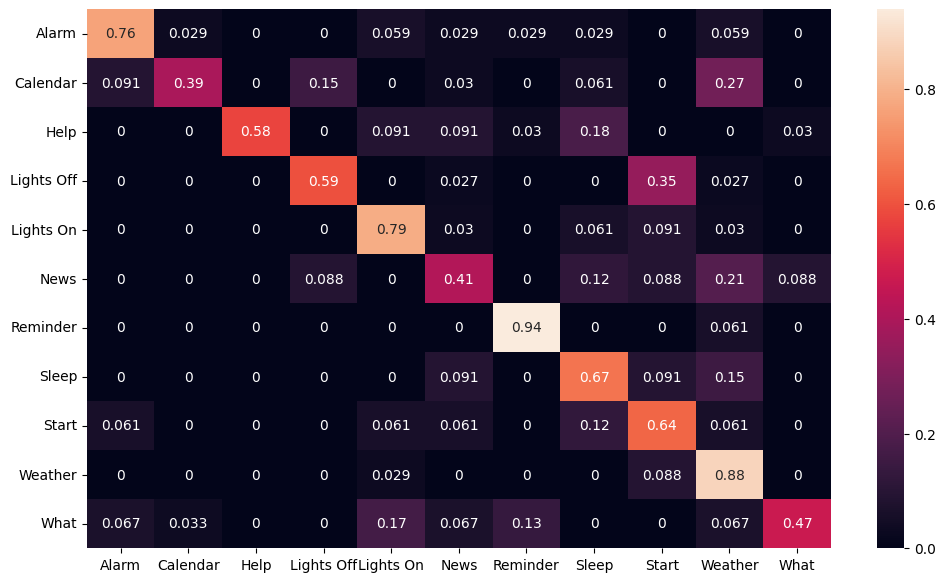

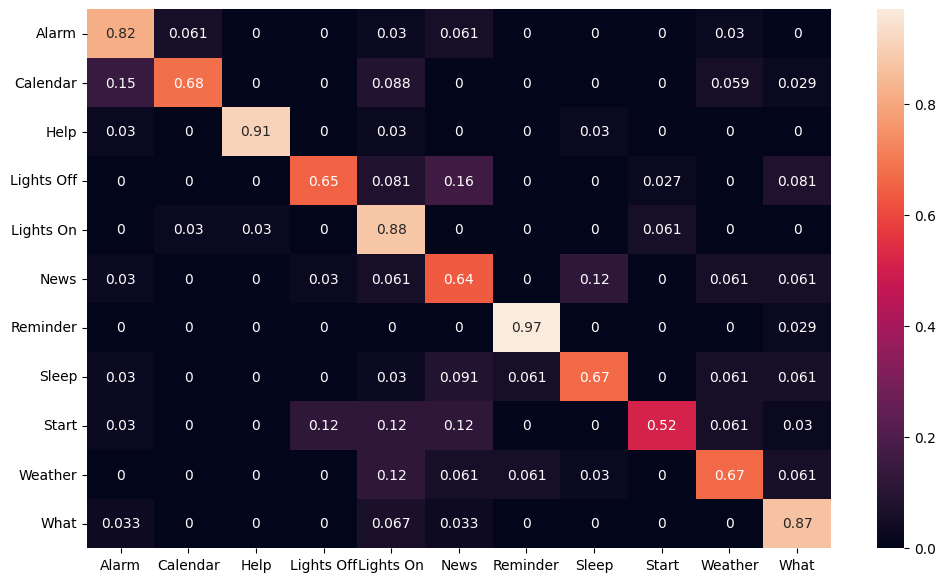

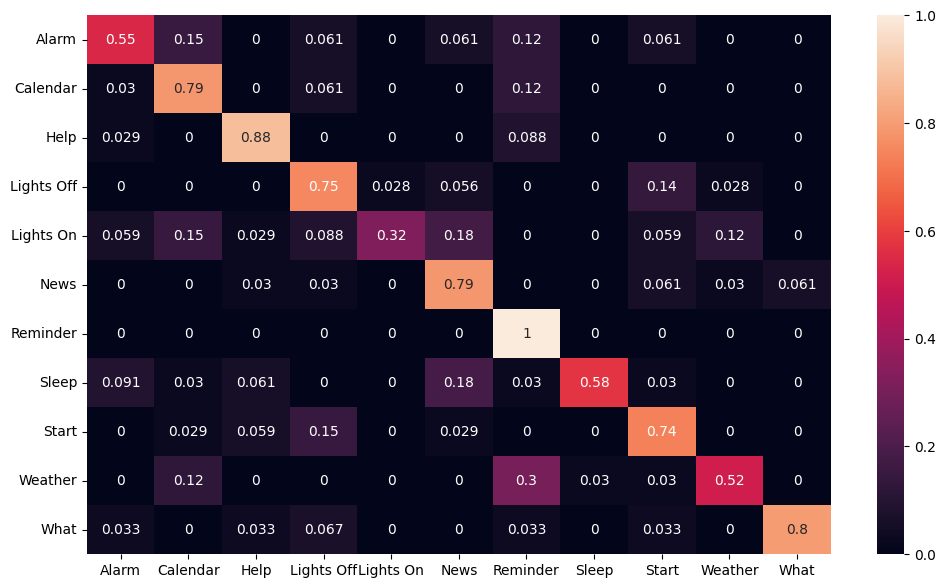

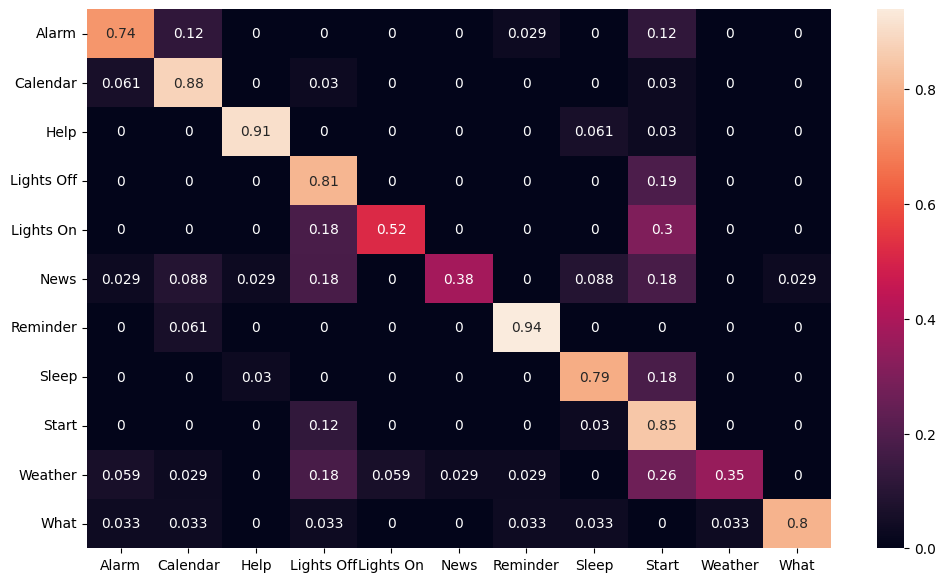

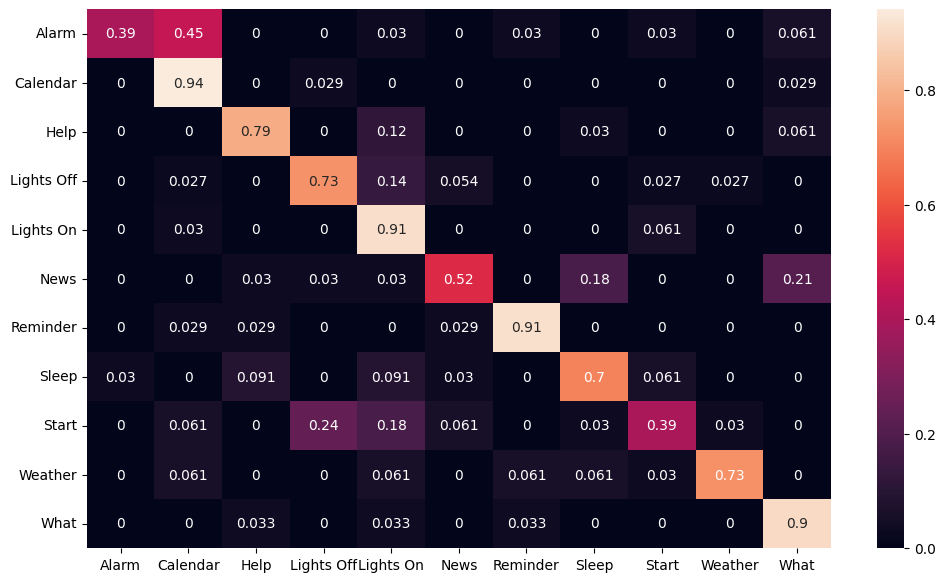

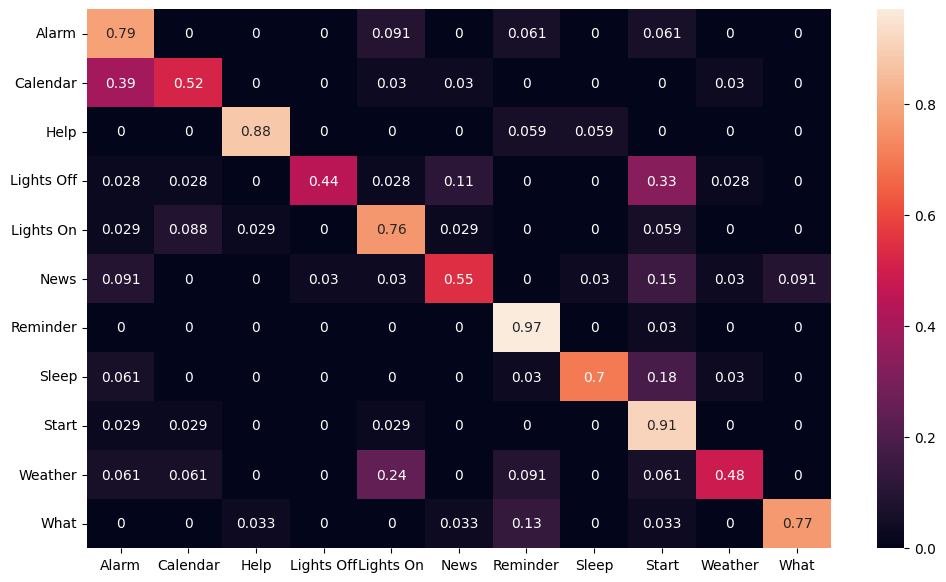

In [ ]:
#@title Run k-fold tests

# batch_size=10
# num_epochs=20
# lr=1e-3
# k_fold_num=3

batch_size=16
num_epochs=20
lr=1e-4
# lr=1e-5
# lr=2e-5
k_fold_num=3

# batch_size=16
# num_epochs=1
# lr=1e-4
# k_fold_num=2

### Triples with varying doppler receiver

# run_triple_multi_depth_cross_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler1","m1",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_triple_multi_depth_cross_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler2","m2",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_triple_multi_depth_cross_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler3","m3",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# ### Doubles with Rx1Rx2 and varying doppler receiver

# run_double_multi_depth_cross_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler1","m1",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_double_multi_depth_cross_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler2","m2",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx12",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_double_multi_depth_cross_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler3","m3",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx12",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)


# ### Doubles with Rx1Rx3 and varying doppler receiver

# run_double_multi_depth_cross_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler1","m1",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx13",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_double_multi_depth_cross_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler2","m2",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_double_multi_depth_cross_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler3","m3",
#                                                   "/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# #Singles global attention

# run_single_multi_depth_global_self_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler1","m1",
#                                          batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_multi_depth_global_self_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler2","m2",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_multi_depth_global_self_attention_classifier_k_fold("/content/microdoppler_dataset/microdoppler3","m3",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_multi_depth_global_self_attention_classifier_k_fold("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_multi_depth_global_self_attention_classifier_k_fold("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)


# #Singles no attention

# run_single_multi_depth_classifier_k_fold("/content/microdoppler_dataset/microdoppler1","m1",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_multi_depth_classifier_k_fold("/content/microdoppler_dataset/microdoppler2","m2",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_multi_depth_classifier_k_fold("/content/microdoppler_dataset/microdoppler3","m3",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_multi_depth_classifier_k_fold("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_multi_depth_classifier_k_fold("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# #singles no depth no attention

# run_single_classifier_k_fold("/content/microdoppler_dataset/microdoppler1","m1",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_classifier_k_fold("/content/microdoppler_dataset/microdoppler2","m2",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_classifier_k_fold("/content/microdoppler_dataset/microdoppler3","m3",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_classifier_k_fold("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

# run_single_classifier_k_fold("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,k_fold_num,global_pooling=True)

## VGG test

# run_vgg_test_k_fold("/content/microdoppler_dataset/microdoppler1","m1",
#                                                   batch_size,num_epochs,lr,k_fold_num)

# run_vgg_test_k_fold("/content/microdoppler_dataset/microdoppler2","m2",
#                                                   batch_size,num_epochs,lr,k_fold_num)

# run_vgg_test_k_fold("/content/microdoppler_dataset/microdoppler3","m3",
#                                                   batch_size,num_epochs,lr,k_fold_num)

# run_vgg_test_k_fold("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx2","Rx12",
#                                                   batch_size,num_epochs,lr,k_fold_num)

# run_vgg_test_k_fold("/content/microdoppler_dataset/Interferometric_Data/Rx1Rx3","Rx13",
#                                                   batch_size,num_epochs,lr,k_fold_num)